# RAG based Credit Decision Research Notebook

A reproducible Jupyter notebook that trains baseline classifiers on the UCI German Credit dataset and computes faithfulness checks using SHAP and LIME. This notebook is is fully deterministic (random seeds), saves artifacts (models, preprocessors), and documents every step so baseline values can be verified.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# drive_path = '/content/drive/MyDrive/Colab Notebooks/22. Research Coding/'

## 1. Loading dependencies & German Credit dataset from UCI

In [3]:
%pip install -r ../requirements.txt


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached numpy-2.3.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached lime-0.2.0.1-py3-none-any.whl
  Using cached shap-0.50.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached clingo-5.8.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (1.2 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached aiofiles-25.1.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)
  Using cached uvicorn-0.38.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached annotated_doc-0.0.4-py3-none-any.whl.metadata (6.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached h11-0.16.0-py3-none-any.wh

In [4]:
# code to verify the python executable path
print("hello", __import__('sys').executable)

hello /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/venv/bin/python


In [5]:
# if required to uninstall existing kernel
#%jupyter kernelspec uninstall venv

In [6]:
# import ipywidgets as widgets
# widgets.IntSlider()

In [7]:
# imports & constants
import sys, platform, random, json, os
RSEED = 42
os.makedirs('models', exist_ok=True)

import numpy as np
import pandas as pd
np.random.seed(RSEED)

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
from pathlib import Path

# optional: xgboost
import xgboost as xgb


# explainability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer


print('setup done')

/Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


setup done


In [8]:
import warnings
warnings.filterwarnings("ignore")

### Load data

In [9]:
# load raw CSV without header
data_path = '../data/statlog-german-credit-data/german_credit_data.csv' # place the UCI csv here
raw = pd.read_csv(data_path, header = None)

raw.shape

(1000, 21)

### Standardize Column names
The UCI German Credit dataset file lacks headers and has 20 attributes + target. Let us assign readable names based on the instructions file in UCI

In [10]:
# set column names (adapted common mapping)
col_names = [
'checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount',
'savings_status', 'employment', 'installment_rate', 'personal_status', 'other_debtors',
'residence_since', 'property', 'age', 'other_installment_plans', 'housing',
'existing_credits', 'job', 'num_dependents', 'telephone', 'foreign_worker', 'target'
]
raw.columns = col_names


# Convert target: in UCI original 1 = good, 2 = bad (or vice versa depending on version).
# We will map to 1 = approve (good), 0 = reject (bad). Check distribution.
raw['target'].value_counts()

target
1    700
2    300
Name: count, dtype: int64

In [11]:
# normalize target to 0/1
# so that 1 = good and 0 = bad where previously 1=good, 2=bad:
raw['target'] = raw['target'].map({1:1, 2:0})
raw['target'].value_counts()

target
1    700
0    300
Name: count, dtype: int64

## 2. EDA

In [12]:
# Basic structure and missingness (UCI notes no missing values)
display(raw.info())
display(raw.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_status          1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_status           1000 non-null   object
 6   employment               1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status          1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

None

checking_status            0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings_status             0
employment                 0
installment_rate           0
personal_status            0
other_debtors              0
residence_since            0
property                   0
age                        0
other_installment_plans    0
housing                    0
existing_credits           0
job                        0
num_dependents             0
telephone                  0
foreign_worker             0
target                     0
dtype: int64

In [13]:
print(raw.describe(include='all').T)
print('\nMissing values per column:\n', raw.isnull().sum())

                          count unique   top freq      mean          std  \
checking_status            1000      4   A14  394       NaN          NaN   
duration                 1000.0    NaN   NaN  NaN    20.903    12.058814   
credit_history             1000      5   A32  530       NaN          NaN   
purpose                    1000     10   A43  280       NaN          NaN   
credit_amount            1000.0    NaN   NaN  NaN  3271.258  2822.736876   
savings_status             1000      5   A61  603       NaN          NaN   
employment                 1000      5   A73  339       NaN          NaN   
installment_rate         1000.0    NaN   NaN  NaN     2.973     1.118715   
personal_status            1000      4   A93  548       NaN          NaN   
other_debtors              1000      3  A101  907       NaN          NaN   
residence_since          1000.0    NaN   NaN  NaN     2.845     1.103718   
property                   1000      4  A123  332       NaN          NaN   
age         

In [14]:
# choose columns
numeric_cols = ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']
# can also use
# numeric_cols = raw.select_dtypes(include=[np.number]).columns.tolist()
# With above numeric columns defined, categorical columns are (excluding target):
cat_cols = [c for c in raw.columns if c not in numeric_cols + ['target']]

print("Categorical columns:", cat_cols)
print("Numerical columns:", numeric_cols)


Categorical columns: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']
Numerical columns: ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']


### EDA: Distribution plots
The UCI page confirms 1000 rows, 20 predictors, and a binary target, with no missing values and a cost matrix (not used in this baseline).​

#### Univariate Analysis

##### Numeric outlier diagnostics (z-score & IQR)
Quick checks for extreme values in numeric_cols using z-score and IQR thresholds.


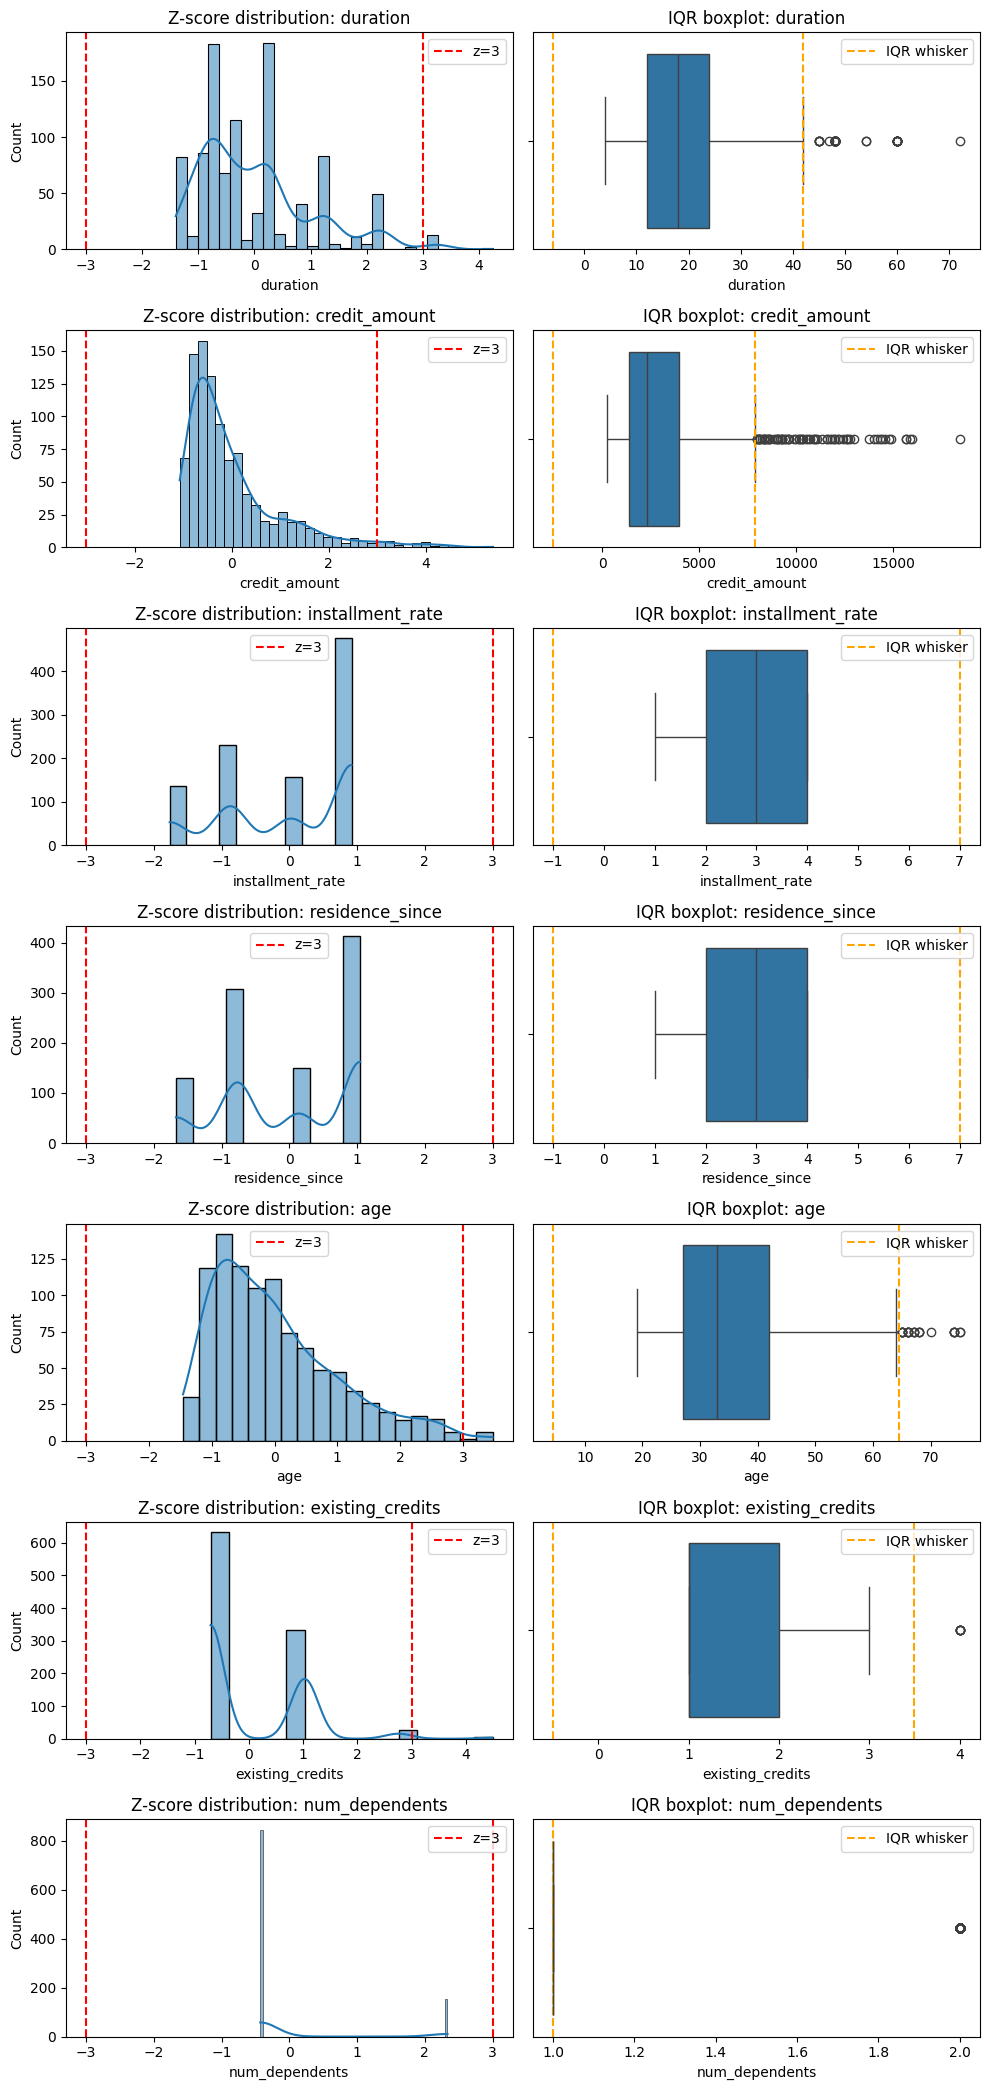

Potential outlier counts (per numeric feature):
                  zscore_gt3  iqr_below  iqr_above
duration                  14          0         70
credit_amount             25          0         72
installment_rate           0          0          0
residence_since            0          0          0
age                        7          0         23
existing_credits           6          0          6
num_dependents             0          0        155


In [15]:
# Numeric outlier diagnostics (z-score & IQR)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Ensure numeric_cols and raw are available from earlier cells
num_cols = numeric_cols

df_num = raw[num_cols].copy()

# Compute z-scores
z_df = df_num.apply(zscore)

# Compute IQR thresholds
q1 = df_num.quantile(0.25)
q3 = df_num.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

fig, axes = plt.subplots(len(num_cols), 2, figsize=(10, 3*len(num_cols)))
for idx, col in enumerate(num_cols):
    # z-score plot
    ax = axes[idx,0] if len(num_cols)>1 else axes[0]
    sns.histplot(z_df[col], kde=True, ax=ax)
    ax.axvline(3, color='r', linestyle='--', label='z=3')
    ax.axvline(-3, color='r', linestyle='--')
    ax.set_title(f"Z-score distribution: {col}")
    ax.legend()
    # IQR boxplot
    ax2 = axes[idx,1] if len(num_cols)>1 else axes[1]
    sns.boxplot(x=df_num[col], ax=ax2, orient='h')
    ax2.axvline(lower[col], color='orange', linestyle='--', label='IQR whisker')
    ax2.axvline(upper[col], color='orange', linestyle='--')
    ax2.set_title(f"IQR boxplot: {col}")
    ax2.legend()
plt.tight_layout()
plt.show()

# Summary counts of potential outliers
outlier_z = (np.abs(z_df) > 3).sum()
outlier_iqr_low = (df_num < lower).sum()
outlier_iqr_high = (df_num > upper).sum()
summary = pd.DataFrame({
    'zscore_gt3': outlier_z,
    'iqr_below': outlier_iqr_low,
    'iqr_above': outlier_iqr_high
})
print("Potential outlier counts (per numeric feature):")
print(summary)


##### Outlier summary
Text summary of potential outliers per numeric feature.


In [16]:
# Summarize outlier counts in text
import pandas as pd

# reuse summary from previous cell; if not present, recompute
try:
    summary_df = summary.copy()
except Exception:
    # recompute quickly
    df_num = raw[numeric_cols].copy()
    from scipy.stats import zscore
    z_df = df_num.apply(zscore)
    q1 = df_num.quantile(0.25)
    q3 = df_num.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_z = (np.abs(z_df) > 3).sum()
    outlier_iqr_low = (df_num < lower).sum()
    outlier_iqr_high = (df_num > upper).sum()
    summary_df = pd.DataFrame({
        'zscore_gt3': outlier_z,
        'iqr_below': outlier_iqr_low,
        'iqr_above': outlier_iqr_high
    })

print(summary_df)

# Simple textual notes
notes = []
for feat, row in summary_df.iterrows():
    zc = int(row['zscore_gt3'])
    il = int(row['iqr_below'])
    ih = int(row['iqr_above'])
    total = len(raw)
    msg = f"{feat}: z>|3|={zc} ({zc/total:.1%}), IQR low={il} ({il/total:.1%}), IQR high={ih} ({ih/total:.1%})"
    notes.append(msg)

print("Outlier summary (counts and % of dataset):")
for line in notes:
    print("-", line)

print("Interpretation: values with small percentages (<1-2%) are mild tail points; larger percentages may warrant capping or inspection, but we keep training pipeline unchanged.")


                  zscore_gt3  iqr_below  iqr_above
duration                  14          0         70
credit_amount             25          0         72
installment_rate           0          0          0
residence_since            0          0          0
age                        7          0         23
existing_credits           6          0          6
num_dependents             0          0        155
Outlier summary (counts and % of dataset):
- duration: z>|3|=14 (1.4%), IQR low=0 (0.0%), IQR high=70 (7.0%)
- credit_amount: z>|3|=25 (2.5%), IQR low=0 (0.0%), IQR high=72 (7.2%)
- installment_rate: z>|3|=0 (0.0%), IQR low=0 (0.0%), IQR high=0 (0.0%)
- residence_since: z>|3|=0 (0.0%), IQR low=0 (0.0%), IQR high=0 (0.0%)
- age: z>|3|=7 (0.7%), IQR low=0 (0.0%), IQR high=23 (2.3%)
- existing_credits: z>|3|=6 (0.6%), IQR low=0 (0.0%), IQR high=6 (0.6%)
- num_dependents: z>|3|=0 (0.0%), IQR low=0 (0.0%), IQR high=155 (15.5%)
Interpretation: values with small percentages (<1-2%) are mild t

Categorical and numerical features are separated, descriptive statistics and distributions are shown

EDA: Categorical distributions


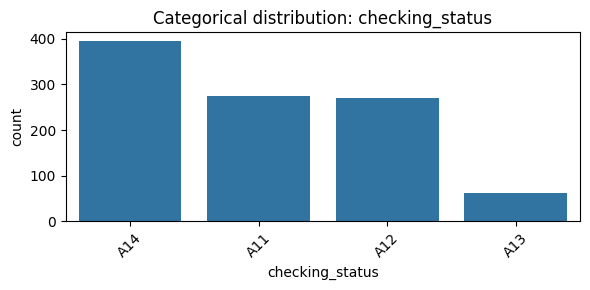

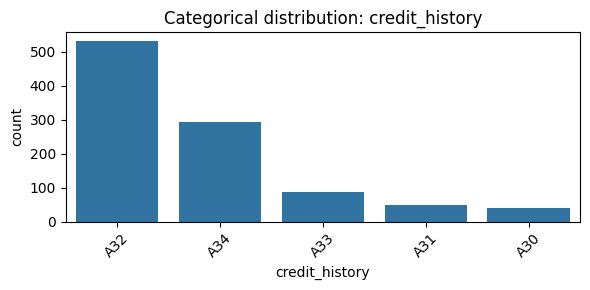

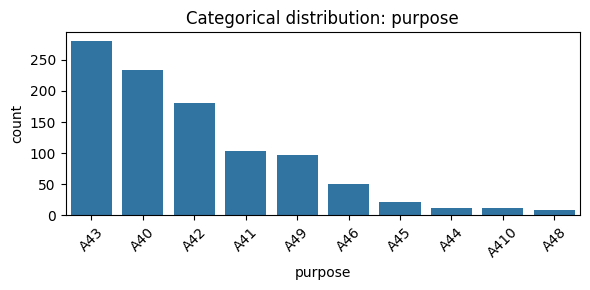

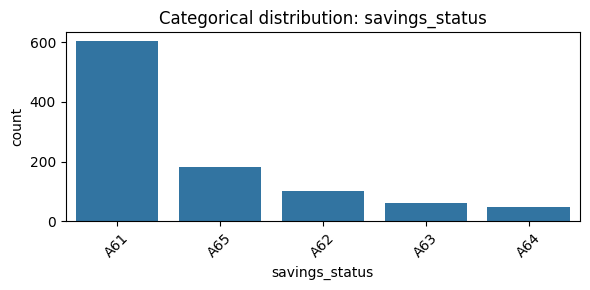

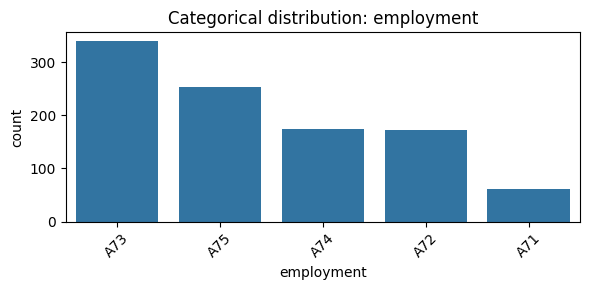

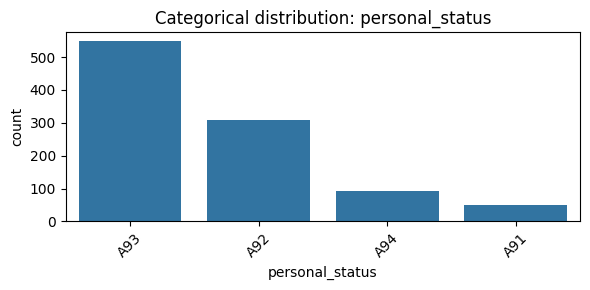

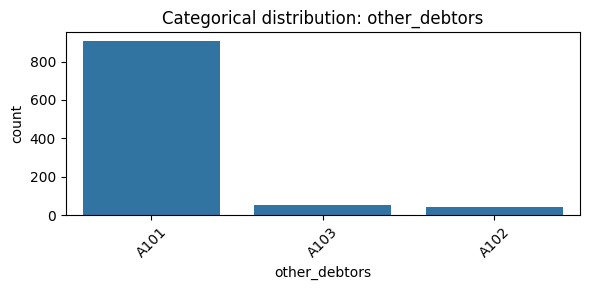

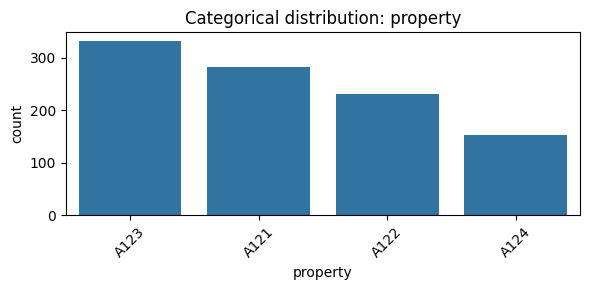

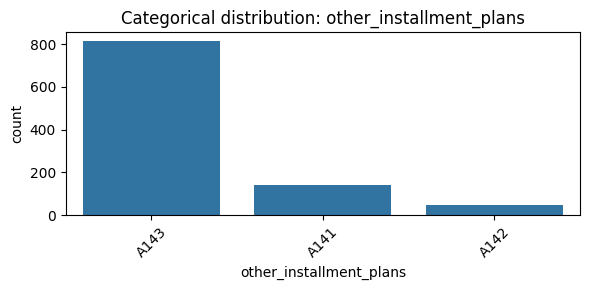

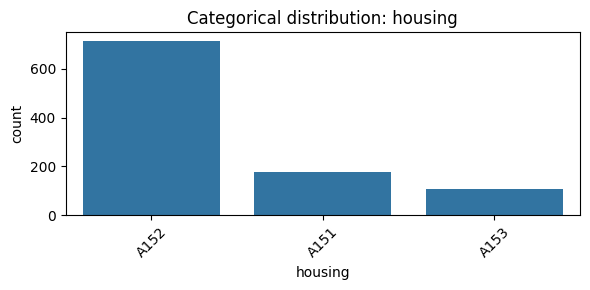

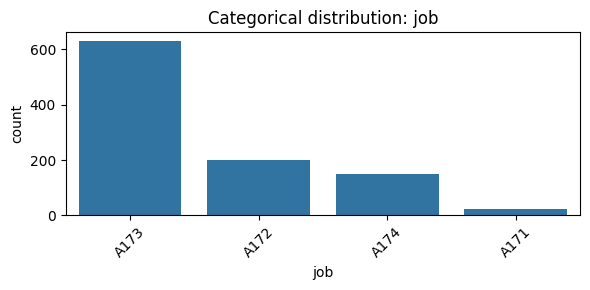

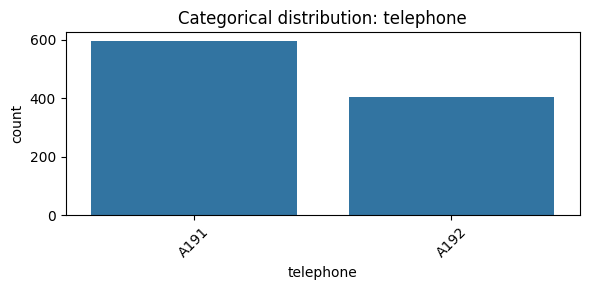

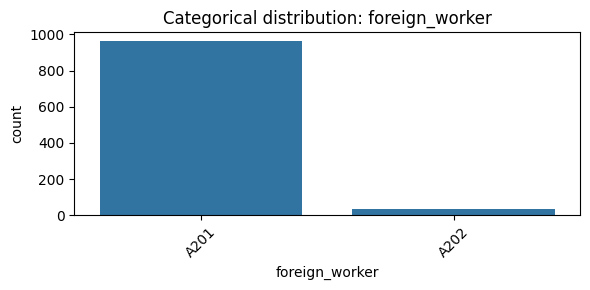

EDA: numerical histograms


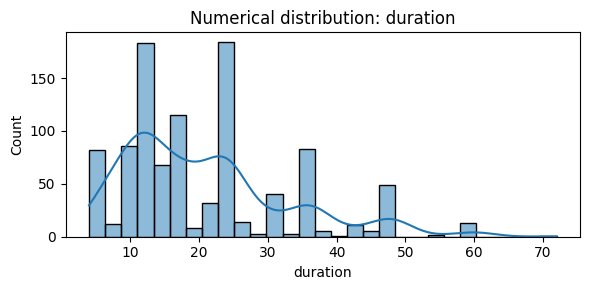

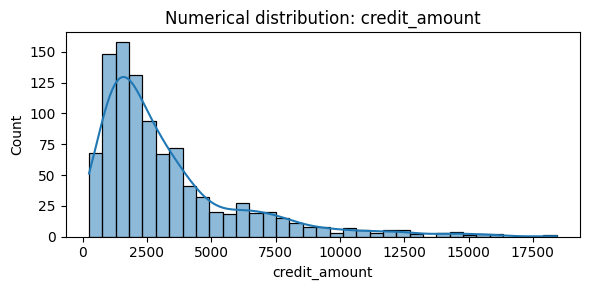

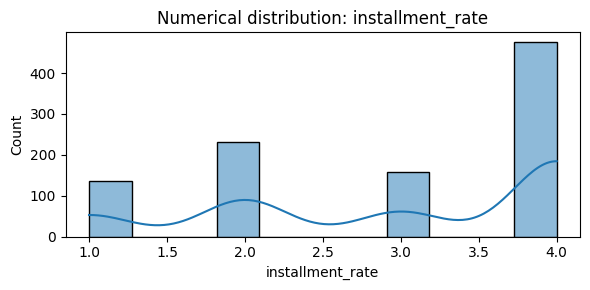

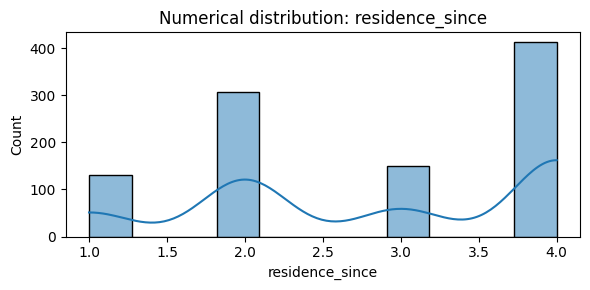

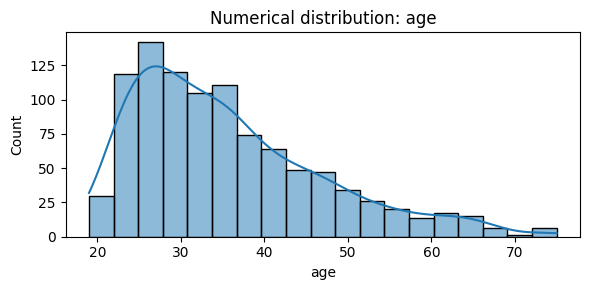

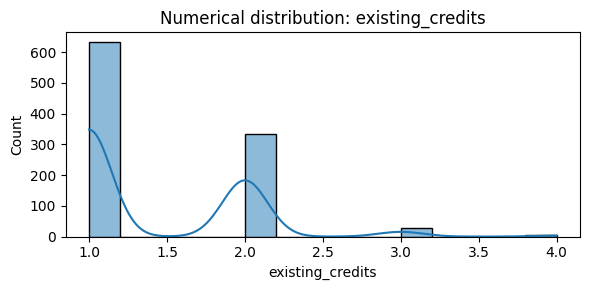

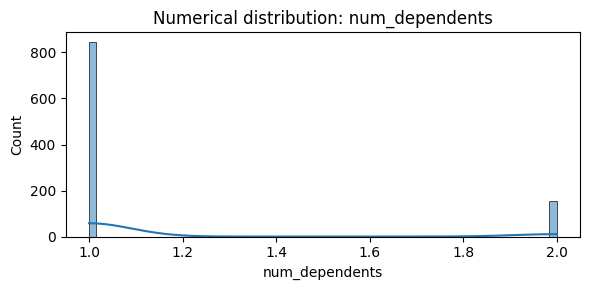

In [17]:
print("EDA: Categorical distributions")
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, data=raw, order=raw[col].value_counts().index)
    plt.title(f"Categorical distribution: {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("EDA: numerical histograms")
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(raw[col], kde=True)
    plt.title(f"Numerical distribution: {col}")
    plt.tight_layout()
    plt.show()

#### BiVariate / chi-square analysis

##### categorical variables vs target:

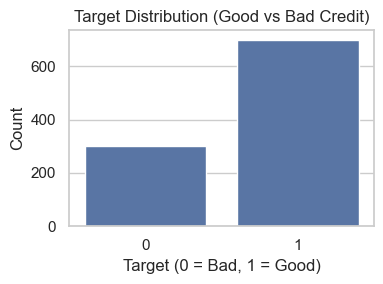

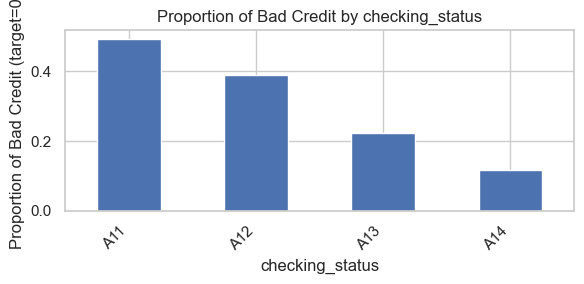

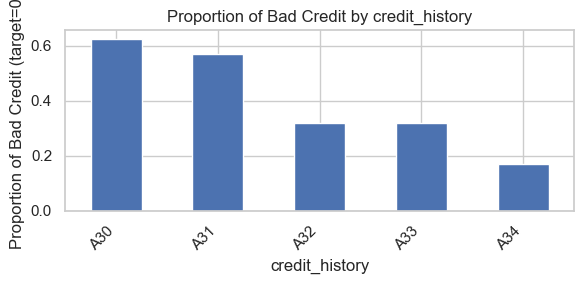

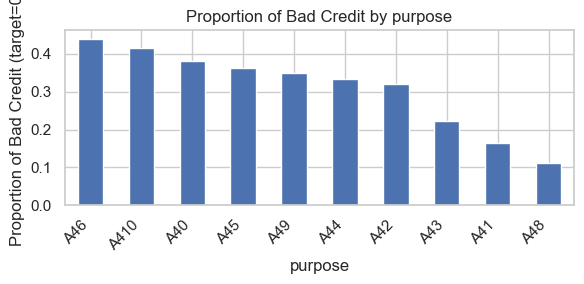

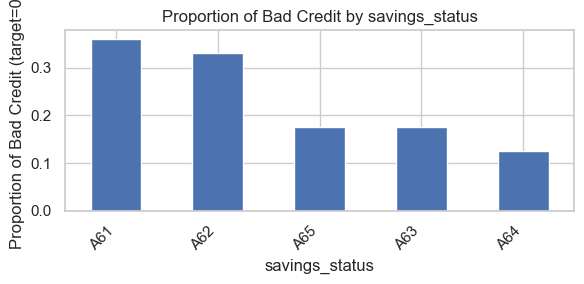

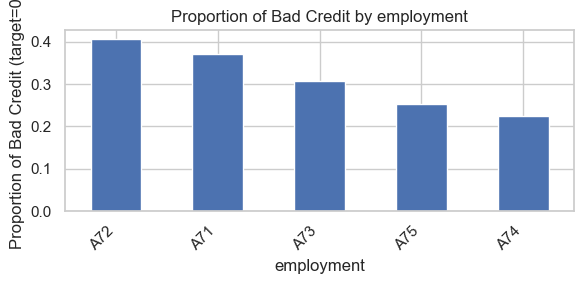

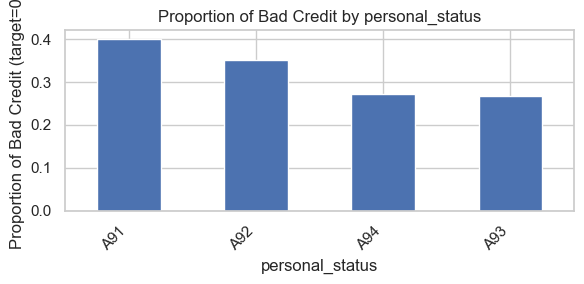

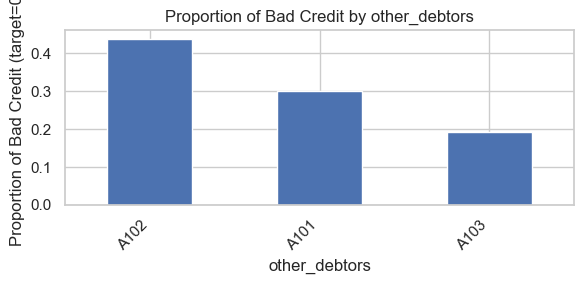

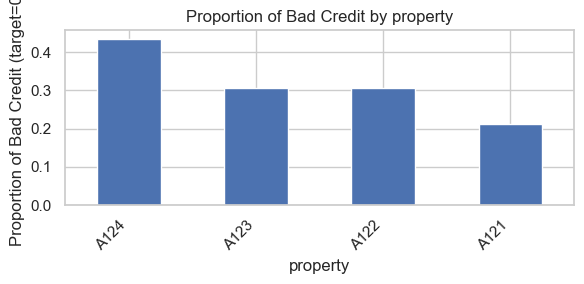

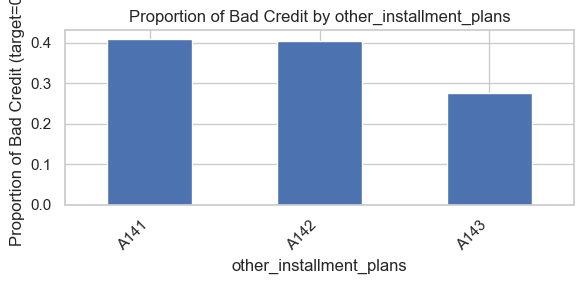

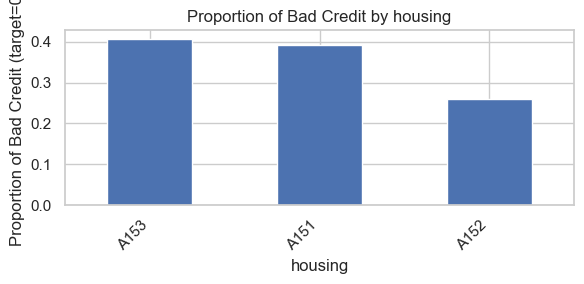

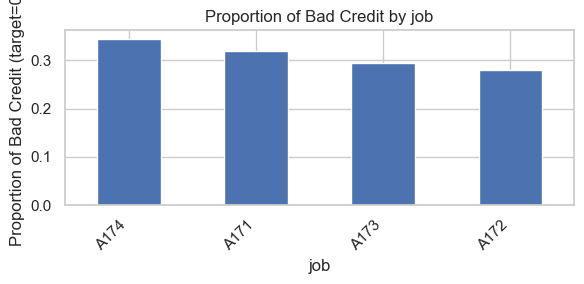

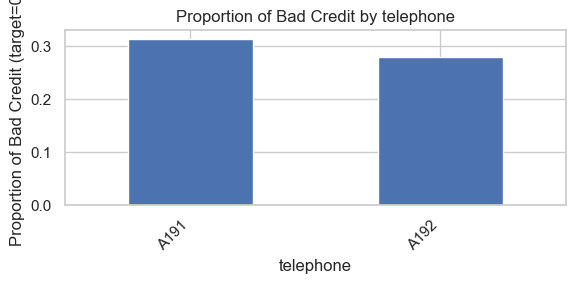

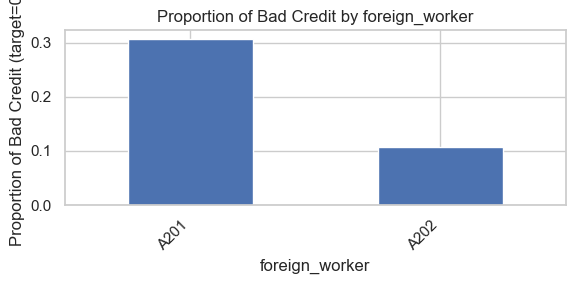

,feature,chi2,p_value,dof
0,checking_status,123.720944,1.218902e-26,3
1,credit_history,61.691397,1.279187e-12,4
3,savings_status,36.098928,2.761214e-07,4
7,property,23.719551,2.858442e-05,3
9,housing,18.199842,1.116747e-04,2


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

sns.set(style="whitegrid")

# Sanity: make sure target is there
assert 'target' in raw.columns, "target column missing"

# 1. Summary: target distribution
plt.figure(figsize=(4, 3))
sns.countplot(x='target', data=raw)
plt.title('Target Distribution (Good vs Bad Credit)')
plt.xlabel('Target (0 = Bad, 1 = Good)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2. Categorical vs target: chi-square + proportion plots
chi2_results = []

for col in cat_cols:
    # contingency table: rows = categories, cols = target values
    ctab = pd.crosstab(raw[col], raw['target'])
    if ctab.shape[0] < 2 or ctab.shape[1] < 2:
        # skip degenerate cases
        continue

    chi2, p, dof, expected = chi2_contingency(ctab)

    chi2_results.append({
        'feature': col,
        'chi2': chi2,
        'p_value': p,
        'dof': dof
    })

    # Proportion of bad credit (target=0) per category
    prop_bad = ctab.div(ctab.sum(axis=1), axis=0)[0]  # column 0 = bad class

    plt.figure(figsize=(6, 3))
    prop_bad.sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Proportion of Bad Credit by {col}')
    plt.ylabel('Proportion of Bad Credit (target=0)')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

chi2_df = pd.DataFrame(chi2_results).sort_values('p_value')
chi2_df.head()


##### Numeric vs target: distributions per class

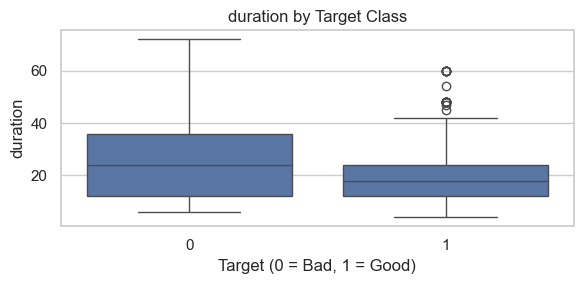

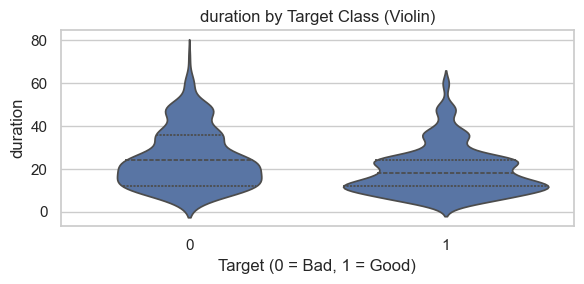

target,0,1
count,300.000000,700.000000
mean,24.860000,19.207143
std,13.282639,11.079564
min,6.000000,4.000000
25%,12.000000,12.000000
50%,24.000000,18.000000
75%,36.000000,24.000000
max,72.000000,60.000000


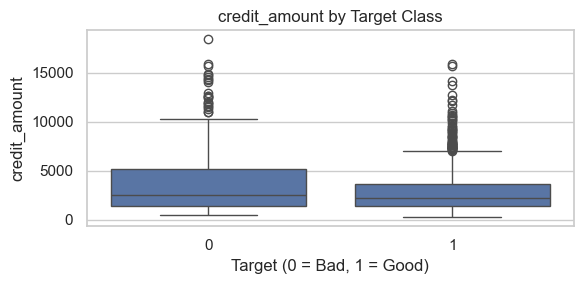

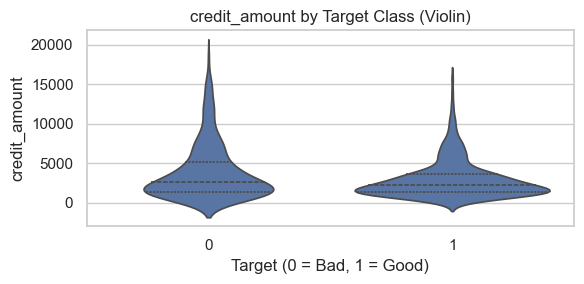

target,0,1
count,300.000000,700.000000
mean,3938.126667,2985.457143
std,3535.818955,2401.472278
min,433.000000,250.000000
25%,1352.500000,1375.500000
50%,2574.500000,2244.000000
75%,5141.500000,3634.750000
max,18424.000000,15857.000000


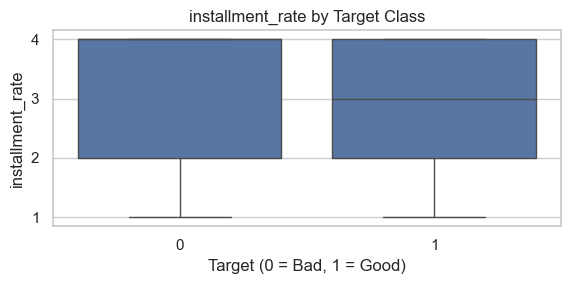

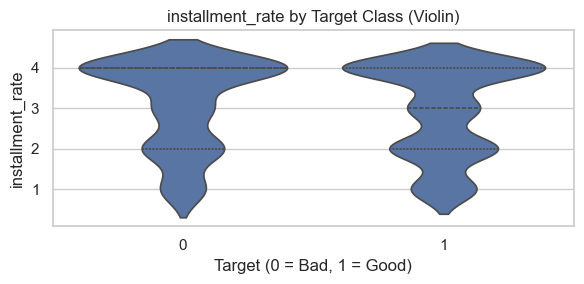

target,0,1
count,300.000000,700.000000
mean,3.096667,2.920000
std,1.088395,1.128078
min,1.000000,1.000000
25%,2.000000,2.000000
50%,4.000000,3.000000
75%,4.000000,4.000000
max,4.000000,4.000000


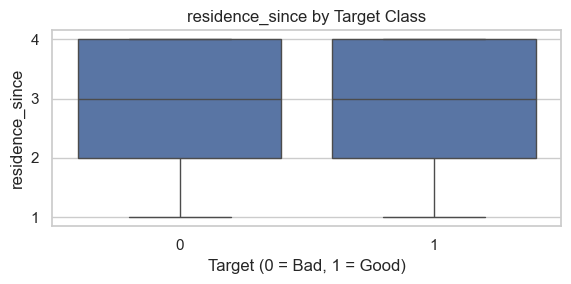

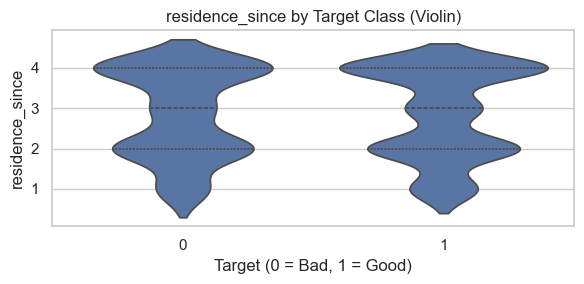

target,0,1
count,300.000000,700.000000
mean,2.850000,2.842857
std,1.094605,1.108373
min,1.000000,1.000000
25%,2.000000,2.000000
50%,3.000000,3.000000
75%,4.000000,4.000000
max,4.000000,4.000000


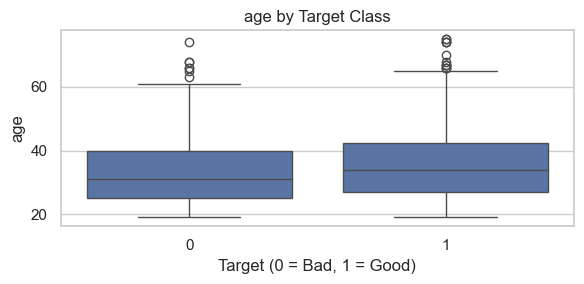

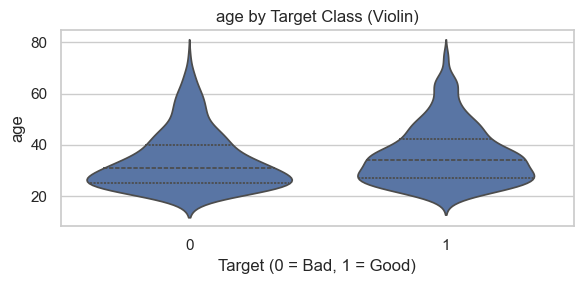

target,0,1
count,300.000000,700.000000
mean,33.963333,36.224286
std,11.222379,11.381145
min,19.000000,19.000000
25%,25.000000,27.000000
50%,31.000000,34.000000
75%,40.000000,42.250000
max,74.000000,75.000000


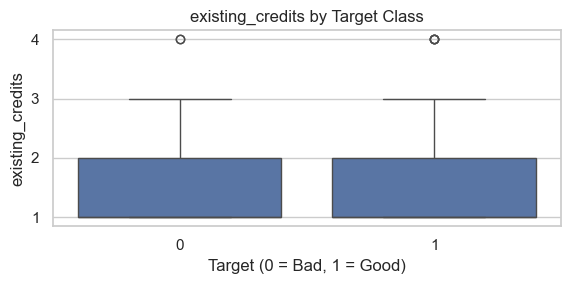

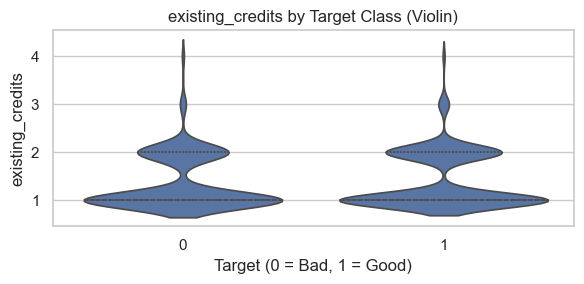

target,0,1
count,300.000000,700.000000
mean,1.366667,1.424286
std,0.559702,0.584721
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,4.000000,4.000000


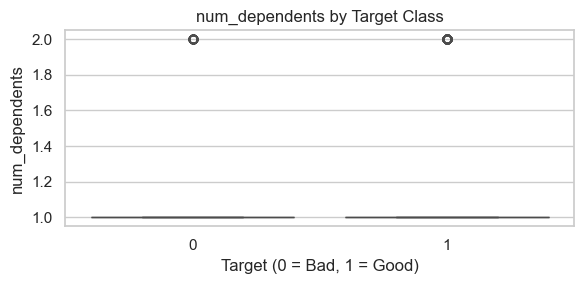

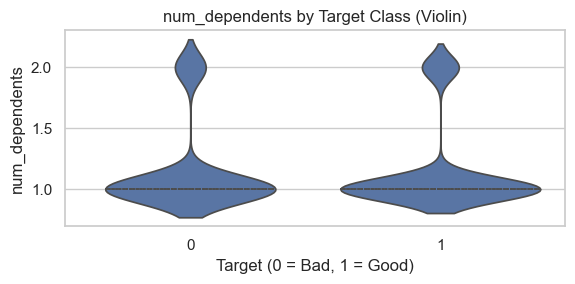

target,0,1
count,300.000000,700.000000
mean,1.153333,1.155714
std,0.360911,0.362844
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,2.000000,2.000000


In [19]:
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=raw, x='target', y=col)
    plt.title(f'{col} by Target Class')
    plt.xlabel('Target (0 = Bad, 1 = Good)')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    # violin plot (gives sense of density)
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=raw, x='target', y=col, inner='quartile')
    plt.title(f'{col} by Target Class (Violin)')
    plt.xlabel('Target (0 = Bad, 1 = Good)')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    # Summary statistics by class
    display(
        raw.groupby('target')[col].describe().T
    )


For numeric variables, boxplots and violin plots by target class were generated, along with summary statistics by class. These visualisations highlight, for example, that rejected applicants tend to have higher credit amounts and shorter residence duration (details in Chapter 5).

##### Correlation Matrix

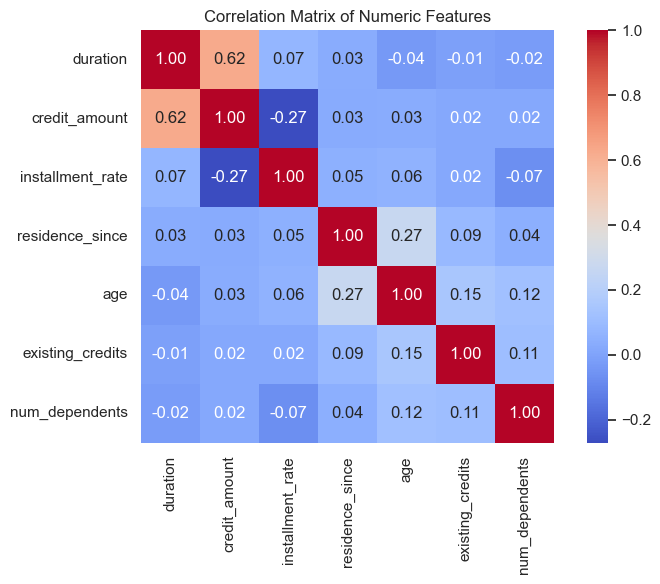

In [20]:
# correlation matrix for numeric variables
corr = raw[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()


# Build pipeline for selecting baseline predictive model

scikit-learn ColumnTransformer applies one-hot encoding to categorical columns and scaling to numeric columns with both including SimpleImputer for imputing missing values as a robust baseline

### Preprocessing: ordinal for ordered cats, OHE for others
Uses OrdinalEncoder for checking_status, savings_status, employment; OHE for remaining categoricals. Saved under models/.


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)
# Ordinal + one-hot preprocessing (explanation/training variant)
from sklearn.preprocessing import OrdinalEncoder

ordinal_cols = ['savings_status', 'employment', 'checking_status']
ordinal_categories = [
    ['A61','A62','A63','A64','A65'],  # savings_status ascending
    ['A71','A72','A73','A74','A75'],  # employment ascending
    ['A11','A12','A13','A14'],        # checking_status ascending
]
cat_cols_v2 = [c for c in raw.columns if c not in numeric_cols + ['target'] + ordinal_cols]

ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1)),
])

categorical_transformer_v2 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('cat', categorical_transformer_v2, cat_cols_v2)
    ]
)

# Helper to get feature names

def get_feature_names(preproc):
    names = list(numeric_cols)
    for col in ordinal_cols:
        names.append(f"{col}_ordinal")
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    for col, cats in zip(cat_cols_v2, ohe.categories_):
        names.extend([f"{col}__{c}" for c in cats])
    return names

Path('models').mkdir(exist_ok=True)
joblib.dump(preprocessor, 'models/preprocessor.joblib')
print('Saved preprocessor to models/preprocessor.joblib')


Saved preprocessor to models/preprocessor.joblib


## Build model pipleines for each model and train

### GridSearchCV with 5-fold (ordinal+OHE preprocessor)
Hyperparameter tuning for LR, RF, XGB, MLP; saves best models to models/.


In [22]:
# split
X = raw.drop(columns=['target'])
y = raw['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RSEED)

# Save raw splits for review
X_train.to_csv('models/X_train_raw.csv', index=False)
X_test.to_csv('models/X_test_raw.csv', index=False)
y_train.to_csv('models/y_train.csv', index=False)
y_test.to_csv('models/y_test.csv', index=False)

In [23]:
# 5-fold GridSearchCV with ordinal+OHE preprocessor
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

models_tuned = {
    'logistic_regression': Pipeline([('preproc', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=RSEED))]),
    'random_forest_balanced': Pipeline([('preproc', preprocessor), ('clf', RandomForestClassifier(random_state=RSEED, class_weight='balanced'))]),
    'random_forest': Pipeline([('preproc', preprocessor), ('clf', RandomForestClassifier(random_state=RSEED, class_weight=None))]),
    'xgboost': Pipeline([('preproc', preprocessor), ('clf', xgb.XGBClassifier(random_state=RSEED, eval_metric='logloss', tree_method='hist'))]),
    'mlp': Pipeline([('preproc', preprocessor), ('clf', MLPClassifier(max_iter=300, random_state=RSEED))]),
}

param_grids = {
    'logistic_regression': {
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs'],
        'clf__class_weight': ['balanced', None]
    },
    'random_forest': {
        'clf__n_estimators': [300, 500, 800],
        'clf__max_depth': [None, 12, 20, 30],
        'clf__max_features': ['sqrt', 'log2'],
        'clf__min_samples_split': [2, 4],
        'clf__min_samples_leaf': [1, 2]
    },
    'random_forest_balanced': {
        'clf__n_estimators': [300, 500, 800],
        'clf__max_depth': [None, 12, 20, 30],
        'clf__max_features': ['sqrt', 'log2'],
        'clf__min_samples_split': [2, 4],
        'clf__min_samples_leaf': [1, 2]
    },
    'xgboost': {
        'clf__n_estimators': [200, 400],
        'clf__max_depth': [3, 5],
        'clf__learning_rate': [0.05, 0.1],
        'clf__subsample': [0.8, 1.0],
    },
    'mlp': {
        'clf__hidden_layer_sizes': [(64,32), (128,64)],
        'clf__alpha': [1e-4, 1e-3],
        'clf__learning_rate_init': [1e-3, 5e-4],
    }
}

results_gs = []
Path('models').mkdir(exist_ok=True)
for name, pipe in models_tuned.items():
    print(f"GridSearchCV for {name}...")
    gs = GridSearchCV(pipe, param_grids[name], cv=cv, scoring='accuracy', n_jobs=-1, refit=True)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    joblib.dump(best, f'models/{name}_pipeline.joblib')
    results_gs.append({'model': name, 'best_params': gs.best_params_, 'best_score': gs.best_score_})
    preds = best.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    print(name, 'accuracy', acc, 'precision', prec)

pd.DataFrame(results_gs).to_csv('models/gridsearch_results_tuned.csv', index=False)
pd.DataFrame(results_gs)


GridSearchCV for logistic_regression...
logistic_regression accuracy 0.735 precision 0.7959183673469388
GridSearchCV for random_forest_balanced...
random_forest_balanced accuracy 0.7 precision 0.773972602739726
GridSearchCV for random_forest...
random_forest accuracy 0.77 precision 0.7901234567901234
GridSearchCV for xgboost...
xgboost accuracy 0.745 precision 0.8027210884353742
GridSearchCV for mlp...
mlp accuracy 0.71 precision 0.7928571428571428


,model,best_params,best_score
0,logistic_regression,"{'clf__C': 0.1, 'clf__class_weight': None, 'cl...",0.77500
1,random_forest_balanced,"{'clf__max_depth': 20, 'clf__max_features': 's...",0.76625
2,random_forest,"{'clf__max_depth': 12, 'clf__max_features': 's...",0.76375
3,xgboost,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.76500
4,mlp,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes...",0.74000


This approach leverages documented best practices for mixed-type tabular data by transforming numeric and categorical subsets with ColumnTransformer for reproducible pipelines

In [24]:
# Helper to get feature names after transformation (v2)

def get_feature_names_from_preprocessor(preproc):
    names = list(numeric_cols)
    # ordinal block
    for col in ['savings_status', 'employment', 'checking_status']:
        names.append(f"{col}_ordinal")
    # one-hot block
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_cols_v2 = [c for c in raw.columns if c not in numeric_cols + ['target'] + ['savings_status','employment','checking_status']]
    for col, cats in zip(cat_cols_v2, ohe.categories_):
        names.extend([f"{col}__{c}" for c in cats])
    return names


## Evaluation of trained models: LR, RF, XGBoost, simple NN

### Performance metrics on test data 

In [25]:
# Load tuned models from GridSearchCV and compute metrics (no retraining)
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import joblib

model_names = ['logistic_regression','random_forest','xgboost','mlp']
models = {name: joblib.load(f"models/{name}_pipeline.joblib") for name in model_names}

results = []
for name, pipe in models.items():
    preds = pipe.predict(X_test)
    probas = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    roc = roc_auc_score(y_test, probas) if probas is not None else float('nan')
    print(name, 'accuracy', acc, 'precision', prec, 'recall', rec, 'f1', f1, 'roc_auc', roc)
    results.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc})

res_df = pd.DataFrame(results)
res_df.to_csv('models/baseline_results.csv', index=False)
res_df


logistic_regression accuracy 0.735 precision 0.7959183673469388 recall 0.8357142857142857 f1 0.8153310104529616 roc_auc 0.7767857142857143
random_forest accuracy 0.77 precision 0.7901234567901234 recall 0.9142857142857143 f1 0.847682119205298 roc_auc 0.7928571428571428
xgboost accuracy 0.745 precision 0.8027210884353742 recall 0.8428571428571429 f1 0.8222996515679443 roc_auc 0.7564285714285715
mlp accuracy 0.71 precision 0.7928571428571428 recall 0.7928571428571428 f1 0.7928571428571428 roc_auc 0.7102380952380953


,model,accuracy,precision,recall,f1,roc_auc
0,logistic_regression,0.735,0.795918,0.835714,0.815331,0.776786
1,random_forest,0.770,0.790123,0.914286,0.847682,0.792857
2,xgboost,0.745,0.802721,0.842857,0.822300,0.756429
3,mlp,0.710,0.792857,0.792857,0.792857,0.710238


For the Random Forest, class weighting was analysed for both versions of 'balanced' and None scenarios. Although the class‐weighted configuration slightly increased cross-validated accuracy, on the held-out test set the unweighted model achieved higher overall accuracy (0.77 vs 0.70) and ROC–AUC (0.79 vs 0.78), and, importantly, a better F1-score for the minority “bad credit” class (0.53 vs 0.47). For this reason, the unweighted Random Forest was retained as the main tree-based model in the subsequent analysis and explanation experiments.

In [26]:
res_df = pd.DataFrame(results)
res_df.to_csv('models/baseline_results.csv', index=False)
res_df

,model,accuracy,precision,recall,f1,roc_auc
0,logistic_regression,0.735,0.795918,0.835714,0.815331,0.776786
1,random_forest,0.770,0.790123,0.914286,0.847682,0.792857
2,xgboost,0.745,0.802721,0.842857,0.822300,0.756429
3,mlp,0.710,0.792857,0.792857,0.792857,0.710238


This baseline reflects standard classifiers for credit scoring and provides accuracy and precision metrics as requested, ensuring reproducibility and clarity in performance reporting

# Determine XAI SHAP and Lime Explanations

## SHAP Integration

#### SHAP visualizations (summary & waterfall for RandomForest)
Generates summary bar and single-instance waterfall/decision plots; saves to models/.


<Figure size 800x600 with 0 Axes>

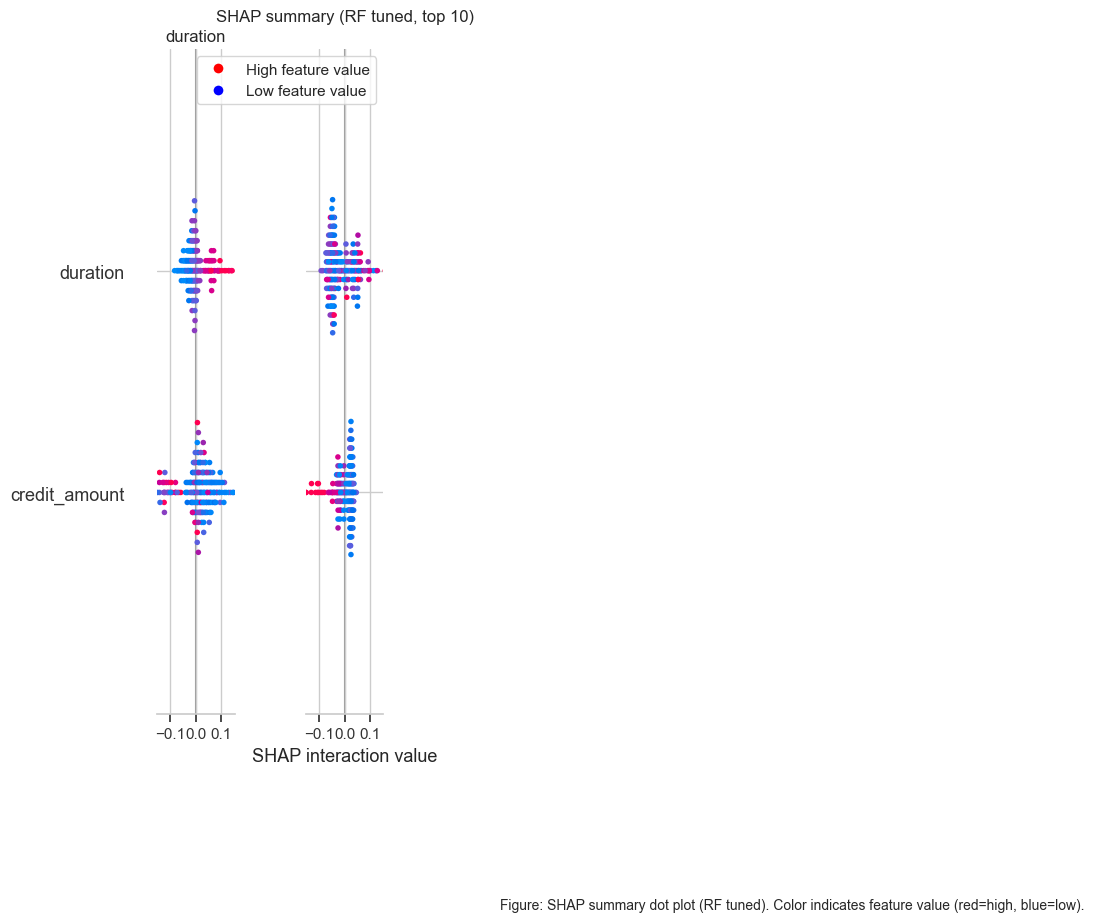

Saved summary plot to models/shap_rf_summary.png
Summary interpretation: higher mean |SHAP| features drive decisions most across the sampled test set.
Colors: red = high feature value pushes prediction toward its sign; blue = low feature value.


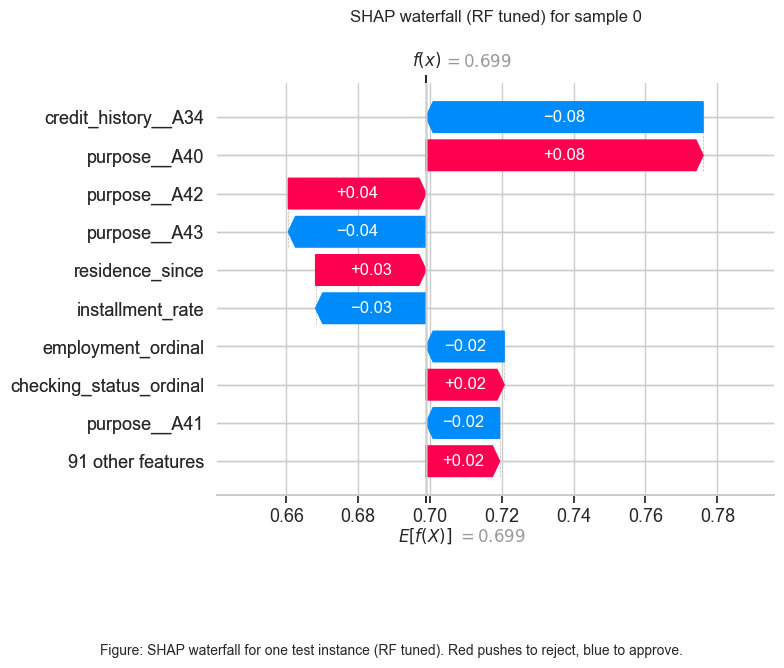

Saved waterfall plot to models/shap_rf_waterfall_sample0.png
Waterfall interpretation: positive bars push towards class 1 (reject), negative towards approve; magnitude shows impact.


In [27]:
# SHAP visualizations for tuned RandomForest (summary + waterfall)
import shap, joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib.lines import Line2D

# Load tuned RF pipeline and data
rf_pipe = joblib.load('models/random_forest_pipeline.joblib')
pre = rf_pipe.named_steps['preproc']
clf = rf_pipe.named_steps['clf']
X_test_raw = pd.read_csv('models/X_test_raw.csv')

# Transform test set
X_test_tx = pre.transform(X_test_raw)
if hasattr(X_test_tx, 'toarray'):
    X_test_tx = X_test_tx.toarray()

# Feature names using current helper
def get_feature_names_from_preprocessor(preproc):
    names = list(numeric_cols)
    for col in ['savings_status', 'employment', 'checking_status']:
        names.append(f"{col}_ordinal")
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_cols_v2 = [c for c in X_test_raw.columns if c not in numeric_cols + ['target'] + ['savings_status','employment','checking_status']]
    for col, cats in zip(cat_cols_v2, ohe.categories_):
        names.extend([f"{col}__{c}" for c in cats])
    return names

feature_names = get_feature_names_from_preprocessor(pre)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_tx)
sv_use = shap_values[1] if isinstance(shap_values, list) else shap_values

Path('models').mkdir(exist_ok=True)

# Summary dot plot (top 10) with legend and caption
plt.figure(figsize=(8,6))
shap.summary_plot(sv_use, features=X_test_tx, feature_names=feature_names, plot_type='dot', max_display=10, show=False)
legend_elems = [
    Line2D([0],[0], marker='o', color='w', label='High feature value', markerfacecolor='red', markersize=8),
    Line2D([0],[0], marker='o', color='w', label='Low feature value', markerfacecolor='blue', markersize=8)
]
plt.legend(handles=legend_elems, loc='upper right')
plt.title('SHAP summary (RF tuned, top 10)', pad=20)
plt.figtext(0.5, -0.08, 'Figure: SHAP summary dot plot (RF tuned). Color indicates feature value (red=high, blue=low).', ha='center', fontsize=10)
plt.tight_layout(rect=[0,0.06,1,0.94])
sum_path = Path('models/shap_rf_summary.png')
plt.savefig(sum_path, dpi=200)
plt.show()
print(f"Saved summary plot to {sum_path}")
print('Summary interpretation: higher mean |SHAP| features drive decisions most across the sampled test set.')
print('Colors: red = high feature value pushes prediction toward its sign; blue = low feature value.')

# Single-instance waterfall for a sample case
sample_idx = 0
sample_shap_row = sv_use[sample_idx]
sample_shap_row = np.array(sample_shap_row, dtype=float).ravel()
sample_base = explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value

plt.figure(figsize=(10,6))
shap.plots._waterfall.waterfall_legacy(sample_base, sample_shap_row, feature_names=feature_names, max_display=10, show=False)
plt.title(f'SHAP waterfall (RF tuned) for sample {sample_idx}', pad=20)
plt.figtext(0.5, -0.08, 'Figure: SHAP waterfall for one test instance (RF tuned). Red pushes to reject, blue to approve.', ha='center', fontsize=10)
plt.tight_layout(rect=[0,0.06,1,0.94])
wf_path = Path('models/shap_rf_waterfall_sample0.png')
plt.savefig(wf_path, dpi=200)
plt.show()
print(f"Saved waterfall plot to {wf_path}")
print('Waterfall interpretation: positive bars push towards class 1 (reject), negative towards approve; magnitude shows impact.')


##### SHAP summary (beeswarm, top 10)
Standard beeswarm summary plot for the tuned RandomForest (top 10 features).


⚠️ Detected 3D Interaction Values. Collapsing to Standard 2D Values...
SHAP Data Shape: (200, 50) (Should be 2D: Samples x Features)


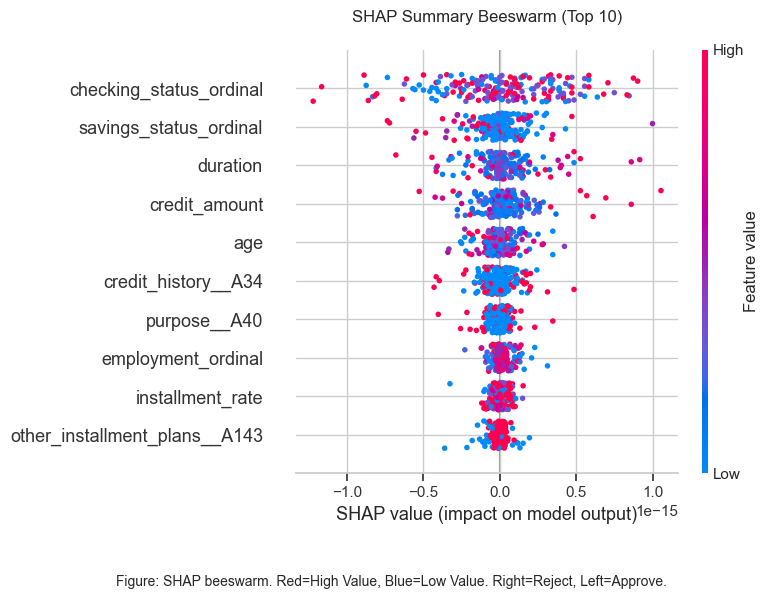

Saved beeswarm plot to models/shap_rf_beeswarm_top10.png


In [28]:
import shap
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib.lines import Line2D

# 1. Load resources
rf_pipe = joblib.load('models/random_forest_pipeline.joblib')
pre = rf_pipe.named_steps['preproc']
clf = rf_pipe.named_steps['clf']
X_test_raw = pd.read_csv('models/X_test_raw.csv')

# 2. Preprocess Data
X_test_tx = pre.transform(X_test_raw)
if hasattr(X_test_tx, 'toarray'):
    X_test_tx = X_test_tx.toarray()

# 3. Get Feature Names
def get_feature_names_from_preprocessor(preproc):
    names = list(numeric_cols) # Ensure numeric_cols is defined
    for col in ['savings_status', 'employment', 'checking_status']:
        names.append(f"{col}_ordinal")
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_cols_v2 = [c for c in X_test_raw.columns if c not in numeric_cols + ['target'] + ['savings_status','employment','checking_status']]
    for col, cats in zip(cat_cols_v2, ohe.categories_):
        names.extend([f"{col}__{c}" for c in cats])
    return names

feature_names = get_feature_names_from_preprocessor(pre)
# SAFETY FIX 1: Convert feature_names to numpy array for safer indexing
feature_names = np.array(feature_names)

# 4. Generate SHAP Values (Force 2D)
explainer = shap.TreeExplainer(clf)
shap_values_raw = explainer.shap_values(X_test_tx)

# Handle Binary Classification list output
if isinstance(shap_values_raw, list):
    sv_use = shap_values_raw[1]
else:
    sv_use = shap_values_raw

# SAFETY FIX 2: Check for Interaction Values (3D) and flatten if necessary
if sv_use.ndim == 3:
    print("⚠️ Detected 3D Interaction Values. Collapsing to Standard 2D Values...")
    # Summing across the interaction dimension retrieves the standard SHAP value
    sv_use = sv_use.sum(axis=2) 
    
print(f"SHAP Data Shape: {sv_use.shape} (Should be 2D: Samples x Features)")

# 5. Select Top 10 Features
# Calculate mean absolute importance
mean_abs = np.abs(sv_use).mean(axis=0)

# Get indices of top 10
top_idx = np.argsort(mean_abs)[-10:][::-1]

# Subset the data (using numpy array indexing)
sv_top = sv_use[:, top_idx]
X_top = X_test_tx[:, top_idx]
feat_top = feature_names[top_idx] # This now works because feature_names is an array

# 6. Plot Beeswarm
Path('models').mkdir(exist_ok=True)
plt.figure(figsize=(8,6))

shap.summary_plot(sv_top, features=X_top, feature_names=feat_top, plot_type='dot', show=False)

# Custom Legend
# legend_elems = [
#     Line2D([0],[0], marker='o', color='w', label='High feature value', markerfacecolor='red', markersize=8),
#     Line2D([0],[0], marker='o', color='w', label='Low feature value', markerfacecolor='blue', markersize=8)
# ]
#plt.legend(handles=legend_elems, loc='lower right')
plt.title('SHAP Summary Beeswarm (Top 10)', pad=20)
plt.figtext(0.5, -0.08, 'Figure: SHAP beeswarm. Red=High Value, Blue=Low Value. Right=Reject, Left=Approve.', ha='center', fontsize=10)
plt.tight_layout()

bs_path = Path('models/shap_rf_beeswarm_top10.png')
plt.savefig(bs_path, dpi=200)
plt.show()
print(f"Saved beeswarm plot to {bs_path}")

SHAP values for a sample of test instances and top-k features extracted.

* For tree models (RandomForest, XGBoost) shap.TreeExplainer is used.
* For linear models shap.LinearExplainer is used.
* For MLP shap.KernelExplainer on a small sample is used .

### Compute SHAP top-k values for RF and XGBoost

In [29]:
# prepare feature names using preprocessor fitted inside a pipeline saved (we used pipeline preproc)
# load one pipeline to extract preprocessor fitted on training data
pipe_rf = joblib.load('models/random_forest_pipeline.joblib')
preproc_fitted = pipe_rf.named_steps['preproc']
feature_names = get_feature_names_from_preprocessor(preproc_fitted)
len(feature_names), feature_names[:20]

(50,
 ['duration',
  'credit_amount',
  'installment_rate',
  'residence_since',
  'age',
  'existing_credits',
  'num_dependents',
  'savings_status_ordinal',
  'employment_ordinal',
  'checking_status_ordinal',
  'credit_history__A30',
  'credit_history__A31',
  'credit_history__A32',
  'credit_history__A33',
  'credit_history__A34',
  'purpose__A40',
  'purpose__A41',
  'purpose__A410',
  'purpose__A42',
  'purpose__A43'])

In [30]:
# Safe scalar extraction helper
def to_float_scalar(x):
    # Works if x is scalar, 0-d array, or shape (1,) or (1,1)
    return float(np.ravel(np.asarray(x))[0])

SHAP TreeExplainer is used for tree-based models to compute exact SHAP values efficiently, and LIME’s LimeTabularExplainer is used to generate local surrogate explanations; both tools are applied on the transformed feature space with feature names recovered from the ColumnTransformer to extract and persist top-k factors per instance.

In [31]:
# Utility: get transformed feature names from the fitted preprocessor
def get_feature_names(fitted_preprocessor):
    # scikit-learn >= 1.0
    return fitted_preprocessor.get_feature_names_out()

# Prepare transformed data and names for explanations
X_train_tx = preproc_fitted.transform(X_train)
X_test_tx = preproc_fitted.transform(X_test)
feature_names = get_feature_names(preproc_fitted)

# Ensure dense arrays for explainers
if hasattr(X_train_tx, "toarray"):
    X_train_tx = X_train_tx.toarray()
if hasattr(X_test_tx, "toarray"):
    X_test_tx = X_test_tx.toarray()

# SHAP for tree models (RandomForest, XGBoost)
def shap_topk_for_tree_model(pipeline, X_explain, feature_names, top_k=5, model_name="RandomForest"):
    tree_model = pipeline.named_steps["clf"]
    explainer = shap.TreeExplainer(tree_model)
    shap_values = explainer.shap_values(X_explain)
    # Handle binary classification outputs across SHAP versions
    if isinstance(shap_values, list) and len(shap_values) == 2:
        sv = shap_values[1]  # class 1 = bad risk
    else:
        sv = shap_values  # already a 2D array
    rows = []
    for i in range(X_explain.shape[0]):
        abs_vals = np.abs(sv[i])
        top_idx = np.argsort(abs_vals)[-top_k:][::-1]
        row = {"instance_id": i}
        for j in range(top_k):
            row[f"feat_{j+1}"] = feature_names[top_idx[j]]
            row[f"shap_{j+1}"] = to_float_scalar(sv[i, top_idx[j]])
        rows.append(row)
    out_df = pd.DataFrame(rows)
    out_path = f"models/shap_topk_{model_name}.csv"
    out_df.to_csv(out_path, index=False)
    return out_df, out_path

rf_shap_df, rf_shap_path = shap_topk_for_tree_model(models["random_forest"], X_test_tx, feature_names, top_k=5, model_name="RandomForest")
xgb_shap_df, xgb_shap_path = shap_topk_for_tree_model(models["xgboost"], X_test_tx, feature_names, top_k=5, model_name="XGBoost")

rf_shap_path,xgb_shap_path


('models/shap_topk_RandomForest.csv', 'models/shap_topk_XGBoost.csv')

TreeExplainer computes fast and exact SHAP values for ensembles, enabling consistent extraction of feature-level attributions per instance for RandomForest and XGBoost.

#### Compute SHAP values for 100 test samples:

In [32]:
# sample test rows
sample_idx = np.random.RandomState(RSEED).choice(X_test.index, size=min(100, len(X_test)), replace=False)
X_test_sample = X_test.loc[sample_idx]

# get transformed matrix for explainer
X_test_proc = preproc_fitted.transform(X_test_sample)

In [33]:
# Build separate explainers per model type
shap_tables = {}
for name in ['random_forest', 'xgboost', 'logistic_regression', 'mlp']:
  pipe = joblib.load(f'models/{name}_pipeline.joblib')
  clf = pipe.named_steps['clf']
  print('Explaining', name)

  explainer_output = None # To store the direct output of explainer.shap_values

  if name in ['random_forest', 'xgboost']:
    explainer = shap.TreeExplainer(clf)
    explainer_output = explainer.shap_values(X_test_proc)
  elif name == 'logistic_regression':
    explainer = shap.LinearExplainer(clf, X_test_proc, feature_perturbation='interventional')
    explainer_output = explainer.shap_values(X_test_proc)
  else: # mlp
    background = X_test_proc[np.random.RandomState(RSEED).choice(X_test_proc.shape[0], size=min(50, X_test_proc.shape[0]), replace=False)]
    explainer = shap.KernelExplainer(clf.predict_proba, background)
    explainer_output = explainer.shap_values(X_test_proc, nsamples=100)

  # Consistently extract SHAP values for the positive class (index 1)
  if isinstance(explainer_output, list):
    # This covers cases where explainer returns a list of arrays (e.g., [shap_0, shap_1])
    shap_vals_use = explainer_output[1]
  elif isinstance(explainer_output, np.ndarray) and explainer_output.ndim == 3:
    # This covers cases where explainer returns a 3D array (samples, features, classes)
    shap_vals_use = explainer_output[:, :, 1]
  else:
    # Assume it's already the 2D array for the positive class (samples, features)
    shap_vals_use = explainer_output

  # Convert to dataframe of mean absolute contribution per feature
  mean_abs = np.abs(shap_vals_use).mean(axis=0)
  feat_imp = pd.DataFrame({'feature': feature_names, 'mean_abs_shap': mean_abs}).sort_values('mean_abs_shap', ascending=False)
  shap_tables[name] = feat_imp
  feat_imp.head(10).to_csv(f'models/shap_top10_{name}.csv', index=False)

Explaining random_forest
Explaining xgboost
Explaining logistic_regression
Explaining mlp


100%|██████████| 100/100 [00:00<00:00, 158.65it/s]


##### Print and Load data

In [34]:
# Example output: top 10 per model
for name, df in shap_tables.items():
  print(name)
  print(df.head(10))

random_forest
                              feature  mean_abs_shap
9                ord__checking_status       0.082558
7                 ord__savings_status       0.030079
1                  num__credit_amount       0.029166
0                       num__duration       0.025641
14            cat__credit_history_A34       0.023173
4                            num__age       0.022187
15                   cat__purpose_A40       0.019889
8                     ord__employment       0.016068
2               num__installment_rate       0.015781
38  cat__other_installment_plans_A143       0.014560
xgboost
                    feature  mean_abs_shap
9      ord__checking_status       1.052889
1        num__credit_amount       0.800307
0             num__duration       0.444336
7       ord__savings_status       0.417093
4                  num__age       0.382844
16         cat__purpose_A41       0.366281
14  cat__credit_history_A34       0.340553
8           ord__employment       0.321921
3      n

### Faithfulness checks

 Correlate top-k SHAP features with model decision by removing top features and measuring drop in predicted probability.

In [35]:
# Cell 11 (REVISED): Faithfulness ablation test (robust and repeatable)
# Computes probability drop when ablating the top-k SHAP features for multiple test instances.

import numpy as np
import pandas as pd
import joblib

# PARAMETERS (tune as needed)
MODEL_NAME = 'random_forest'   # which saved pipeline to test: 'logistic','random_forest','xgboost','mlp'
TOP_K = 3                      # top-k SHAP features to ablate
N_SAMPLES = 50                 # number of test instances to evaluate (or min available)
RSEED = 42                     # ensure same sampling as notebook

# load pipeline and extract preprocessor + classifier
pipe = joblib.load(f'models/{MODEL_NAME}_pipeline.joblib')
pre = pipe.named_steps['preproc']
clf = pipe.named_steps['clf']

# load test set (fall back to saved CSV if variables not in scope)
try:
    X_test  # if variable exists in notebook scope
except NameError:
    X_test = pd.read_csv('models/X_test_raw.csv')
    # y_test not strictly needed here, but available if desired:
    try:
        y_test = pd.read_csv('models/y_test.csv', squeeze=True)
    except Exception:
        pass

# deterministic sample of test indices
rng = np.random.RandomState(RSEED)
sample_idx = rng.choice(X_test.index, size=min(N_SAMPLES, len(X_test)), replace=False)
X_sample = X_test.loc[sample_idx]

# transform to processed feature space
X_proc = pre.transform(X_sample)

# helper: get feature names after preprocessing
def get_feature_names_safe(preproc, numeric_cols_hint=None, cat_cols_hint=None):
    try:
        # scikit-learn >=1.0
        return list(preproc.get_feature_names_out())
    except Exception:
        # fallback: attempt to reconstruct names
        if numeric_cols_hint is None:
            numeric_cols_hint = ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']
        try:
            ohe = preproc.named_transformers_['cat'].named_steps['onehot']
            cat_cols = cat_cols_hint if cat_cols_hint is not None else [c for c in X_sample.columns if c not in numeric_cols_hint]
            cat_names = []
            for col, cats in zip(cat_cols, ohe.categories_):
                cat_names.extend([f"{col}__{c}" for c in cats])
        except Exception:
            cat_names = [c for c in X_sample.columns if c not in numeric_cols_hint]
        return numeric_cols_hint + cat_names

feature_names = get_feature_names_safe(pre)

# compute SHAP values for the chosen model on our sample
print('computing SHAP values for', MODEL_NAME)
if MODEL_NAME in ['random_forest', 'xgboost']:
    explainer = shap.TreeExplainer(clf)
    shap_vals = explainer.shap_values(X_proc)
    # for binary classification shap_vals is often a list; pick class-1 attributions
    if isinstance(shap_vals, list):
        shap_vals_use = shap_vals[1]
    elif shap_vals.ndim == 3:
        shap_vals_use = shap_vals[:, :, 1]
    else:
        shap_vals_use = shap_vals
elif MODEL_NAME == 'logistic_regression':
    explainer = shap.LinearExplainer(clf, X_proc, feature_perturbation='interventional')
    shap_vals_use = explainer.shap_values(X_proc)
else:  # mlp or other
    # KernelExplainer may be slow; use small background
    background = X_proc[rng.choice(X_proc.shape[0], size=min(50, X_proc.shape[0]), replace=False)]
    explainer = shap.KernelExplainer(clf.predict_proba, background)
    sv = explainer.shap_values(X_proc, nsamples=100)
    if isinstance(sv, list):
        shap_vals_use = sv[1]
    elif sv.ndim == 3:
        shap_vals_use = sv[:, :, 1]
    else:
        shap_vals_use = sv

# For each sample instance, ablate the top-k SHAP features and measure probability drop
prob_drops = []
orig_probas = []
new_probas = []
ablated_features_list = []
sample_indices = []

for i in range(X_proc.shape[0]):
    inst_proc = X_proc[i:i+1].copy()
    orig_proba = clf.predict_proba(inst_proc)[0, 1]            # probability for class 1
    # Ensure we use 1D SHAP values for feature importance calculation
    topk_idx = np.argsort(-np.abs(shap_vals_use[i, :]))[:TOP_K]  # indices of top-k features by abs SHAP
    topk_features = [feature_names[j] if j < len(feature_names) else f'feat_{j}' for j in topk_idx]

    proc_ablated = inst_proc.copy()
    proc_ablated[:, topk_idx] = 0.0   # simple ablation: zero-out those processed features

    new_proba = clf.predict_proba(proc_ablated)[0, 1]
    prob_drop = orig_proba - new_proba

    prob_drops.append(float(prob_drop))
    orig_probas.append(float(orig_proba))
    new_probas.append(float(new_proba))
    ablated_features_list.append(topk_features)
    sample_indices.append(X_sample.index[i])

# Build dataframe & save
faithfulness_summary = pd.DataFrame({
    'index': sample_indices,
    'orig_proba': orig_probas,
    'new_proba': new_probas,
    'prob_drop': prob_drops,
    'ablated_features': ablated_features_list
})

print('Mean probability drop after ablating top', TOP_K, 'features:', faithfulness_summary['prob_drop'].mean())

faithfulness_summary.to_csv('models/faithfulness_summary.csv', index=False)

# Aggregated summary for reviewers
agg = {
    'model': MODEL_NAME,
    'top_k': TOP_K,
    'n_samples': len(faithfulness_summary),
    'mean_prob_drop': float(faithfulness_summary['prob_drop'].mean()),
    'median_prob_drop': float(faithfulness_summary['prob_drop'].median())
}
pd.DataFrame([agg]).to_csv('models/faithfulness_agg_summary.csv', index=False)

computing SHAP values for random_forest
Mean probability drop after ablating top 3 features: 0.10410178502276263


#### Faithfulness Visualization


Model: random_forest
Samples evaluated: 50
Top-K (ablated): 3
Mean probability drop (top-K ablation): 0.1041
Median probability drop: 0.1306
Percentage of instances with >5% probability drop: 62.0%
Percentage of instances with any drop (>0): 68.0%

Saved textual summary to models/faithfulness_summary_text.txt


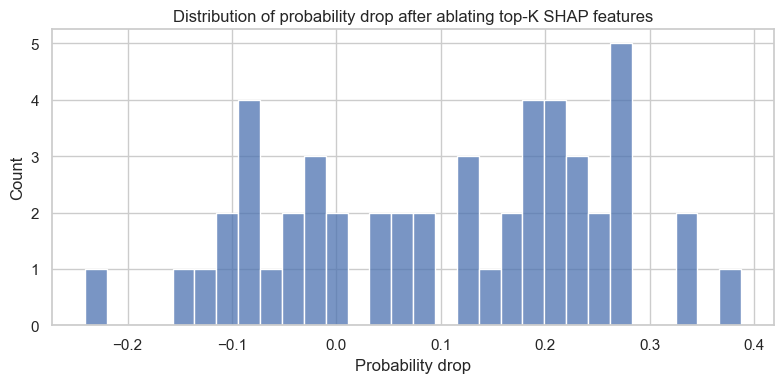

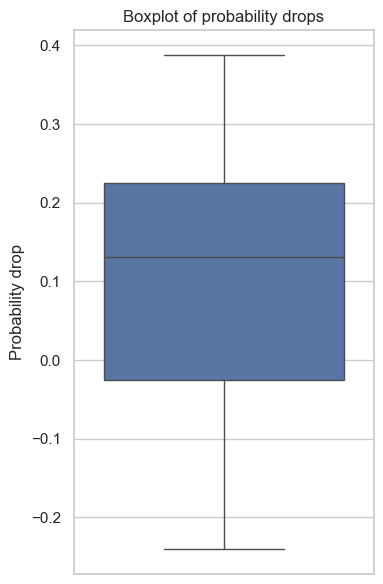

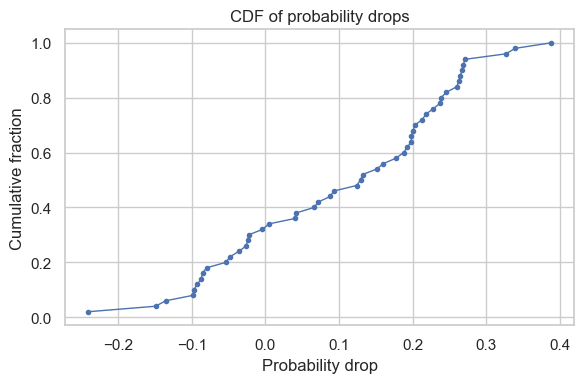

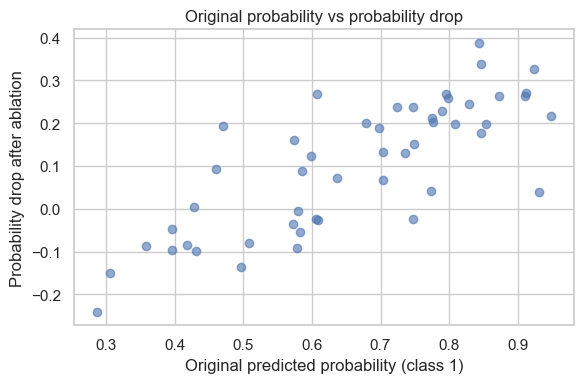

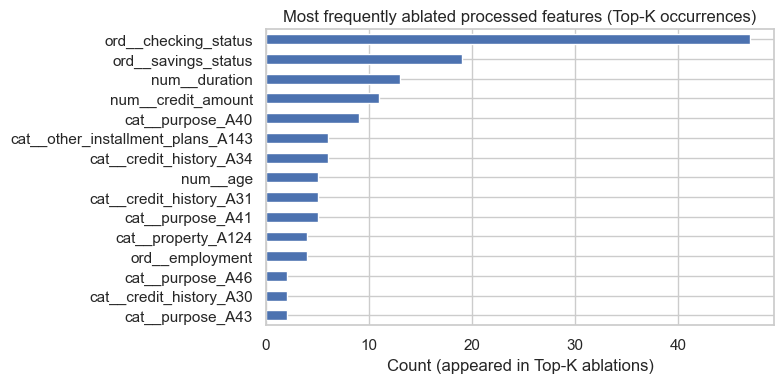

Saved plots to models/: faithfulness_probdrop_hist.png, faithfulness_probdrop_box.png, faithfulness_probdrop_cdf.png, faithfulness_origprob_vs_drop.png (if orig_proba present), faithfulness_top_ablated_features.png (if data available)

Faithfulness analysis:

Dataset: German Credit (UCI).
Model evaluated: random_forest.
Number of instances sampled: 50.
Top-K ablated: 3.

Results:
- Mean probability drop after ablating top-3 SHAP features: 0.1041
- Median probability drop: 0.1306
- Percentage of instances with probability drop > 5%: 62.0%
- Percentage of instances with any probability drop (>0): 68.0%

Interpretation:
A higher mean (and median) probability drop indicates that SHAP-identified features are actually influential for the model's predictions, supporting faithfulness of the explanations. The distribution of drops (histogram, CDF) and the scatter of original prediction vs drop help reveal whether strong explanations are concentrated in high-confidence predictions or are uniform

In [36]:
# Consolidate faithfulness results, produce figures, and print summary

os.makedirs('models', exist_ok=True)

# -- Load CSVs --
faith_path = 'models/faithfulness_summary.csv'
agg_path = 'models/faithfulness_agg_summary.csv'

faith_df = pd.read_csv(faith_path)
agg_df = pd.read_csv(agg_path) if os.path.exists(agg_path) else None

# If ablated_features stored as stringified lists, convert to lists
if 'ablated_features' in faith_df.columns:
    def _safe_eval(x):
        try:
            return ast.literal_eval(x) if isinstance(x, str) else x
        except Exception:
            return x
    faith_df['ablated_features'] = faith_df['ablated_features'].apply(_safe_eval)

# -- Basic numeric summaries --
if agg_df is not None:
    model_name = agg_df.loc[0, 'model'] if 'model' in agg_df.columns else 'unknown'
    top_k = int(agg_df.loc[0, 'top_k']) if 'top_k' in agg_df.columns else None
    n_samples = int(agg_df.loc[0, 'n_samples']) if 'n_samples' in agg_df.columns else len(faith_df)
    mean_drop = float(agg_df.loc[0, 'mean_prob_drop']) if 'mean_prob_drop' in agg_df.columns else float(faith_df['prob_drop'].mean())
    median_drop = float(agg_df.loc[0, 'median_prob_drop']) if 'median_prob_drop' in agg_df.columns else float(faith_df['prob_drop'].median())
else:
    model_name = 'unknown'
    top_k = None
    n_samples = len(faith_df)
    mean_drop = float(faith_df['prob_drop'].mean())
    median_drop = float(faith_df['prob_drop'].median())

pct_gt_5 = (faith_df['prob_drop'] > 0.05).mean() * 100
pct_gt_0 = (faith_df['prob_drop'] > 0.0).mean() * 100

# -- Frequency of ablated features (which processed features appear most in Top-K) --
feature_counts = {}
if 'ablated_features' in faith_df.columns:
    for row in faith_df['ablated_features'].dropna():
        if isinstance(row, (list, tuple)):
            for feat in row:
                feature_counts[feat] = feature_counts.get(feat, 0) + 1
feature_counts = pd.Series(feature_counts).sort_values(ascending=False)

# -- Save textual summary for thesis (human-friendly) --
summary_lines = [
    f"Model: {model_name}",
    f"Samples evaluated: {n_samples}",
    f"Top-K (ablated): {top_k if top_k is not None else 'N/A'}",
    f"Mean probability drop (top-K ablation): {mean_drop:.4f}",
    f"Median probability drop: {median_drop:.4f}",
    f"Percentage of instances with >5% probability drop: {pct_gt_5:.1f}%",
    f"Percentage of instances with any drop (>0): {pct_gt_0:.1f}%"
]
summary_text = "\n".join(summary_lines)
with open('models/faithfulness_summary_text.txt', 'w') as f:
    f.write(summary_text)

print(summary_text)
print("\nSaved textual summary to models/faithfulness_summary_text.txt")

# -- PLOTTING: produce and save figures for thesis --
sns.set(style="whitegrid")

# 1) Histogram of probability drops
plt.figure(figsize=(8,4))
sns.histplot(faith_df['prob_drop'].values, bins=30, kde=False)
plt.title('Distribution of probability drop after ablating top-K SHAP features')
plt.xlabel('Probability drop')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('models/faithfulness_probdrop_hist.png', dpi=200)
plt.show()

plt.close()

# 2) Boxplot of drops
plt.figure(figsize=(4,6))
sns.boxplot(y=faith_df['prob_drop'].values)
plt.title('Boxplot of probability drops')
plt.ylabel('Probability drop')
plt.tight_layout()
plt.savefig('models/faithfulness_probdrop_box.png', dpi=200)
plt.show()

plt.close()

# 3) CDF of probability drops
vals = np.sort(faith_df['prob_drop'].values)
cdf = np.arange(1, len(vals)+1) / float(len(vals))
plt.figure(figsize=(6,4))
plt.plot(vals, cdf, marker='.', linewidth=1)
plt.xlabel('Probability drop')
plt.ylabel('Cumulative fraction')
plt.title('CDF of probability drops')
plt.grid(True)
plt.tight_layout()
plt.savefig('models/faithfulness_probdrop_cdf.png', dpi=200)
plt.show()

plt.close()

# 4) Scatter: original probability vs prob_drop
if 'orig_proba' in faith_df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(faith_df['orig_proba'], faith_df['prob_drop'], alpha=0.6)
    plt.xlabel('Original predicted probability (class 1)')
    plt.ylabel('Probability drop after ablation')
    plt.title('Original probability vs probability drop')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('models/faithfulness_origprob_vs_drop.png', dpi=200)
    plt.show()
    plt.close()

# 5) Bar chart: most frequently ablated processed features (Top 15)
if not feature_counts.empty:
    top_n = min(15, len(feature_counts))
    plt.figure(figsize=(8,4))
    feature_counts.head(top_n).sort_values().plot(kind='barh')
    plt.xlabel('Count (appeared in Top-K ablations)')
    plt.title('Most frequently ablated processed features (Top-K occurrences)')
    plt.tight_layout()
    plt.savefig('models/faithfulness_top_ablated_features.png', dpi=200)
    plt.show()
    plt.close()

print("Saved plots to models/: faithfulness_probdrop_hist.png, faithfulness_probdrop_box.png, faithfulness_probdrop_cdf.png, faithfulness_origprob_vs_drop.png (if orig_proba present), faithfulness_top_ablated_features.png (if data available)")

thesis_paragraph = f"""
Faithfulness analysis:

Dataset: German Credit (UCI).
Model evaluated: {model_name}.
Number of instances sampled: {n_samples}.
Top-K ablated: {top_k if top_k is not None else 'N/A'}.

Results:
- Mean probability drop after ablating top-{top_k if top_k is not None else 'K'} SHAP features: {mean_drop:.4f}
- Median probability drop: {median_drop:.4f}
- Percentage of instances with probability drop > 5%: {pct_gt_5:.1f}%
- Percentage of instances with any probability drop (>0): {pct_gt_0:.1f}%

Interpretation:
A higher mean (and median) probability drop indicates that SHAP-identified features are actually influential for the model's predictions, supporting faithfulness of the explanations. The distribution of drops (histogram, CDF) and the scatter of original prediction vs drop help reveal whether strong explanations are concentrated in high-confidence predictions or are uniform across the sample. The most frequently ablated processed features (saved as an image) show which processed variables (numerical or one-hot encoded categories) commonly drive model decisions across the evaluated instances.
"""

with open('models/faithfulness_paragraph.txt', 'w') as f:
    f.write(thesis_paragraph)

print(f"{thesis_paragraph}")
print("\nSaved the same to models/faithfulness_paragraph.txt\n")


## LIME Integration

LIME library integration for local explanations (model-agnostic)

LimeTabularExplainer provides instance-level explanations by fitting local surrogate models, and the notebook saves the top-k conditions and weights per instance to CSV for auditing.

In [37]:
# Load tuned RF pipeline and data
rf_pipe = joblib.load('models/random_forest_pipeline.joblib')
pre = rf_pipe.named_steps['preproc']
clf = rf_pipe.named_steps['clf']
X_test_raw = pd.read_csv('models/X_test_raw.csv')

# Transform test set
X_test_tx = pre.transform(X_test_raw)
if hasattr(X_test_tx, 'toarray'):
    X_test_tx = X_test_tx.toarray()

# Feature names using current helper
def get_feature_names_from_preprocessor(preproc):
    names = list(numeric_cols)
    for col in ['savings_status', 'employment', 'checking_status']:
        names.append(f"{col}_ordinal")
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_cols_v2 = [c for c in X_test_raw.columns if c not in numeric_cols + ['target'] + ['savings_status','employment','checking_status']]
    for col, cats in zip(cat_cols_v2, ohe.categories_):
        names.extend([f"{col}__{c}" for c in cats])
    return names

feature_names = get_feature_names_from_preprocessor(pre)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_tx,
    feature_names=feature_names,
    class_names=["Good", "Bad"],
    discretize_continuous=True,
    mode="classification",
    random_state=RSEED
)

def lime_topk_for_pipeline(pipeline, X_explain, feature_names, top_k=5, model_name="RandomForest"):
    clf = pipeline.named_steps["clf"]
    # Build predict_proba on transformed features
    def predict_proba_fn(X_array):
        return clf.predict_proba(X_array)
    rows = []
    for i in range(X_explain.shape[0]):
        exp = lime_explainer.explain_instance(
            X_explain[i],
            predict_proba_fn,
            num_features=top_k
        )
        pairs = exp.as_list()
        # Save feature condition string and weight
        row = {"instance_id": i}
        for j, (feat_str, weight) in enumerate(pairs[:top_k]):
            row[f"feat_{j+1}"] = feat_str
            row[f"lime_{j+1}"] = float(weight)
        rows.append(row)
    out_df = pd.DataFrame(rows)
    out_path = f"models/lime_topk_{model_name}.csv"
    out_df.to_csv(out_path, index=False)
    return out_df, out_path

rf_lime_df, rf_lime_path = lime_topk_for_pipeline(models["random_forest"], X_test_tx, feature_names, top_k=5, model_name="RandomForest")
xgb_lime_df, xgb_lime_path = lime_topk_for_pipeline(models["xgboost"], X_test_tx, feature_names, top_k=5, model_name="XGBoost")

rf_lime_path, xgb_lime_path


('models/lime_topk_RandomForest.csv', 'models/lime_topk_XGBoost.csv')

### LIME top-k comparison (RF vs XGB)
Frequency of features appearing in LIME top-k across models; shows top drivers per model.


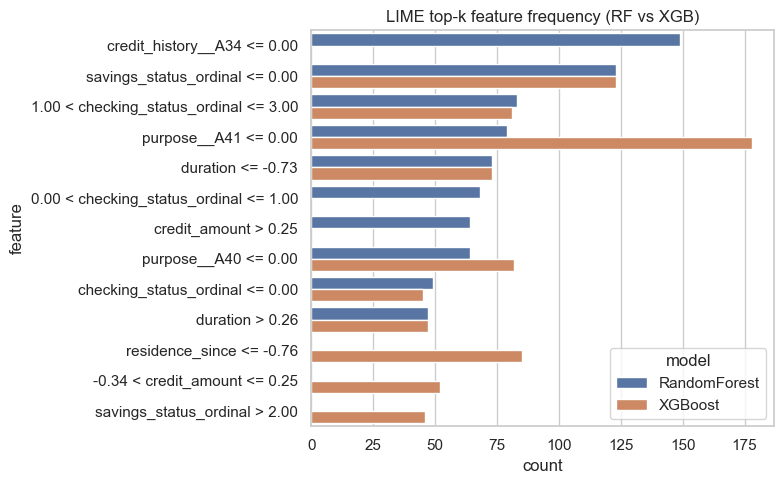

Saved comparison plot to models/lime_topk_feature_compare.png
Top features by model (counts):
       model                                feature  count
RandomForest            credit_history__A34 <= 0.00    149
RandomForest         savings_status_ordinal <= 0.00    123
RandomForest 1.00 < checking_status_ordinal <= 3.00     83
RandomForest                   purpose__A41 <= 0.00     79
RandomForest                      duration <= -0.73     73
RandomForest 0.00 < checking_status_ordinal <= 1.00     68
RandomForest                   credit_amount > 0.25     64
RandomForest                   purpose__A40 <= 0.00     64
RandomForest        checking_status_ordinal <= 0.00     49
RandomForest                        duration > 0.26     47
     XGBoost                   purpose__A41 <= 0.00    178
     XGBoost         savings_status_ordinal <= 0.00    123
     XGBoost               residence_since <= -0.76     85
     XGBoost                   purpose__A40 <= 0.00     82
     XGBoost 1.00 < c

In [38]:
# LIME top-k comparison between RandomForest and XGBoost
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

paths = {
    'RandomForest': Path('models/lime_topk_RandomForest.csv'),
    'XGBoost': Path('models/lime_topk_XGBoost.csv'),
}

freq_rows = []
for model, p in paths.items():
    if not p.exists():
        print(f"Missing {p}, skip {model}")
        continue
    df = pd.read_csv(p)
    feat_cols = [c for c in df.columns if c.startswith('feat_')]
    # count occurrences of each feature string across instances
    counts = df[feat_cols].melt(value_name='feature')['feature'].value_counts()
    top_feats = counts.head(10)
    for feat, cnt in top_feats.items():
        freq_rows.append({'model': model, 'feature': feat, 'count': cnt})

freq_df = pd.DataFrame(freq_rows)
if not freq_df.empty:
    plt.figure(figsize=(8,5))
    sns.barplot(data=freq_df, y='feature', x='count', hue='model')
    plt.title('LIME top-k feature frequency (RF vs XGB)')
    plt.tight_layout()
    out_path = Path('models/lime_topk_feature_compare.png')
    plt.savefig(out_path, dpi=200)
    plt.show()
    print(f"Saved comparison plot to {out_path}")
else:
    print("No LIME top-k files found for comparison.")

print("Top features by model (counts):")
if not freq_df.empty:
    print(freq_df.sort_values(['model','count'], ascending=[True, False]).to_string(index=False))


### LIME visualizations (single instance)
Prediction probability bars and LIME feature contributions for one applicant (RandomForest tuned). Saves plots to models/.


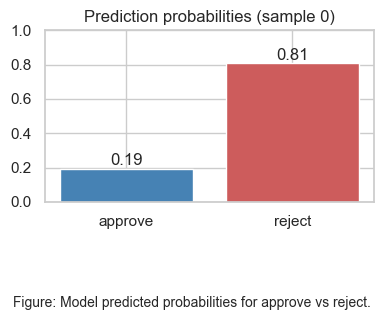

Saved probability bar plot to models/lime_rf_prob_sample0.png


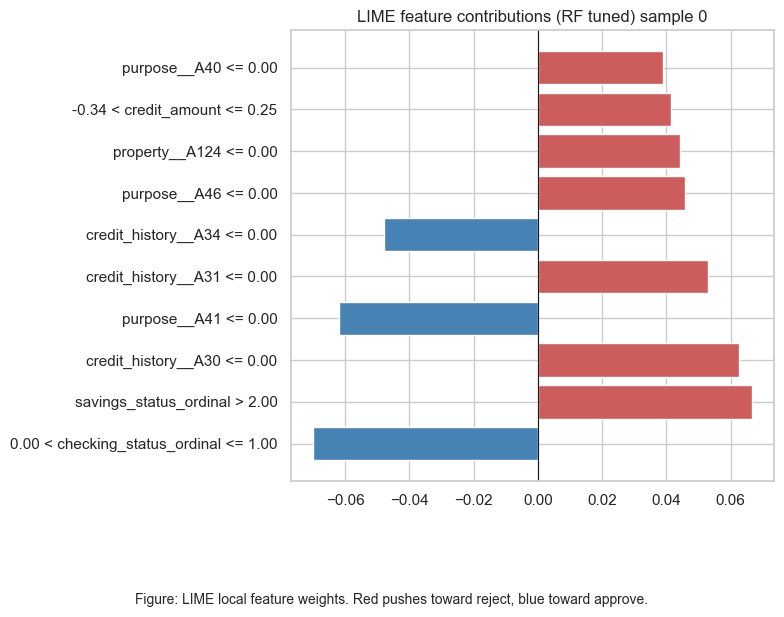

Saved LIME feature plot to models/lime_rf_features_sample0.png


In [39]:
# LIME visualizations for a single test instance
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from pathlib import Path

# Load tuned RF pipeline and data
rf_pipe = joblib.load('models/random_forest_pipeline.joblib')
pre = rf_pipe.named_steps['preproc']
clf = rf_pipe.named_steps['clf']
X_train_raw = pd.read_csv('models/X_train_raw.csv')
X_test_raw = pd.read_csv('models/X_test_raw.csv')

# Transform train/test
X_train_tx = pre.transform(X_train_raw)
X_test_tx = pre.transform(X_test_raw)
if hasattr(X_train_tx, 'toarray'):
    X_train_tx = X_train_tx.toarray()
if hasattr(X_test_tx, 'toarray'):
    X_test_tx = X_test_tx.toarray()

def get_feature_names_from_preprocessor(preproc):
    names = list(numeric_cols)
    for col in ['savings_status', 'employment', 'checking_status']:
        names.append(f"{col}_ordinal")
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_cols_v2 = [c for c in X_train_raw.columns if c not in numeric_cols + ['target'] + ['savings_status','employment','checking_status']]
    for col, cats in zip(cat_cols_v2, ohe.categories_):
        names.extend([f"{col}__{c}" for c in cats])
    return names

feature_names = get_feature_names_from_preprocessor(pre)

# Build LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_tx,
    feature_names=feature_names,
    class_names=["approve", "reject"],
    discretize_continuous=True,
    mode="classification",
    random_state=RSEED,
)

# Pick a test instance
sample_idx = 0
instance = X_test_tx[sample_idx]
raw_instance = X_test_raw.iloc[[sample_idx]]
proba = clf.predict_proba(instance.reshape(1,-1))[0]

# Plot probability bars
plt.figure(figsize=(4,3))
labels = ['approve','reject']
colors = ['steelblue','indianred']
plt.bar(labels, proba, color=colors)
plt.ylim(0,1)
plt.title(f'Prediction probabilities (sample {sample_idx})')
for i,v in enumerate(proba):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.figtext(0.5, -0.15, 'Figure: Model predicted probabilities for approve vs reject.', ha='center', fontsize=10)
plt.tight_layout(rect=[0,0.05,1,0.9])
prob_path = Path('models/lime_rf_prob_sample0.png')
plt.savefig(prob_path, dpi=200)
plt.show()
print(f"Saved probability bar plot to {prob_path}")

# LIME explanation
exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=clf.predict_proba,
    num_features=10
)
weights = exp.as_list()
feat_names_plot = [w[0] for w in weights]
feat_weights_plot = [w[1] for w in weights]
colors_fw = ['indianred' if w>0 else 'steelblue' for w in feat_weights_plot]

plt.figure(figsize=(8,6))
y_pos = np.arange(len(weights))
plt.barh(y_pos, feat_weights_plot, color=colors_fw)
plt.yticks(y_pos, feat_names_plot)
plt.axvline(0, color='k', linewidth=0.8)
plt.title(f'LIME feature contributions (RF tuned) sample {sample_idx}')
plt.figtext(0.5, -0.08, 'Figure: LIME local feature weights. Red pushes toward reject, blue toward approve.', ha='center', fontsize=10)
plt.tight_layout(rect=[0,0.05,1,0.94])
lime_bar_path = Path('models/lime_rf_features_sample0.png')
plt.savefig(lime_bar_path, dpi=200)
plt.show()
print(f"Saved LIME feature plot to {lime_bar_path}")


# Ontology and RAG Preparation (Small retrieval index)

Steps including Building and mapping Ontology with FAISS retrieval index (RAG Prep)

## Create simplified financial ontology (JSON)
Map German Creidt Dataset feattures --> FIBO ontology terms

e.g.,

credit_amount --> fibo:CreditAmount

values mapped to fibo:HighSavings etc.,

### Check and Create directories

In [ ]:
# Create ontology mapping (FIBO-inspired) and build small local retrieval index for regulatory snippets
# - Saves ontology/mapping.json
# - Scans regulatory/*.txt and builds a FAISS index via sentence-transformers
# - Provides helper functions: map_row_to_ontology(), retrieve_regulatory_snippets()
#
import os
import json
from pathlib import Path
from typing import List, Dict
import numpy as np

# --- optional: embedding index dependencies ---
try:
    from sentence_transformers import SentenceTransformer
    import faiss
except Exception as e:
    SentenceTransformer = None
    faiss = None
    print("Note: sentence-transformers/faiss not available. Install 'sentence-transformers faiss-cpu' to enable local retrieval. Proceeding to write ontology file only.")

# create folders
os.makedirs('ontology', exist_ok=True)
os.makedirs('regulatory', exist_ok=True)
os.makedirs('indexes', exist_ok=True)



### Step 1: Load ontology mapping file mapping.json

Moved to `src.rag.load_ontology_mapping()`

In [ ]:
# # Load refined ontology mapping and persist to mapping.json (backward-compatible)
# from pathlib import Path
# import json

# #mapping_path = Path('ontology/mapping-extended.json')
# mapping_path = Path('ontology/mapping.json')
# if not mapping_path.exists():
#     raise FileNotFoundError(f"Missing {mapping_path}")

# ontology_map = json.loads(mapping_path.read_text())

# # Ensure every entry has notes; keep legacy compatibility (string -> ontology_term)
# for col, meta in list(ontology_map.items()):
#     if isinstance(meta, str):
#         ontology_map[col] = {"ontology_term": meta, "notes": "Legacy string entry from mapping.json"}
#         continue
#     meta.setdefault("notes", "See value_map/bins for ontology labeling.")
#     if "value_notes" in meta:
#         meta.setdefault("notes", "; ".join([f"{k}:{v}" for k,v in meta["value_notes"].items()]))

# # Save to legacy mapping.json for downstream consumers
# with legacy_path.open('w', encoding='utf8') as f:
#     json.dump(ontology_map, f, indent=2)
# print(f"Saved ontology mapping to {legacy_path.resolve()}")


### Step 2: Helper: map a raw DataFrame row -> ontology labels (simple mapping)

The below mapper function takes:

* a raw row of data (from a Pandas DataFrame or a Python dictionary)

* an ontology definition (a JSON-like dict that maps column names → ontology terms)

and returns a new dictionary with fibo ontology term mapped to row value

Could moved to `src.rag.map_row_to_ontology()`

In [42]:
# def map_row_to_ontology(row: Dict, ontology: Dict = None) -> Dict:
#     """
#     Convert a single applicant row (dict or pd.Series) into ontology-labeled facts.
#     Returns a dict of ontology_term -> value/label.
#     """
#     if ontology is None:
#         with open(ont_path, 'r', encoding='utf8') as fh:
#             ontology = json.load(fh)
            
#     mapped = {} # result dictionary
    
#     for col, meta in ontology.items():
#         # lets skip derived for now
#         if col == "derived":
#             continue
        
#         # if this ontology column exists in the row then get value and map it
#         if col in row:
#             val = row[col]
#             # Ontology term for this column (fallback uses fibo:col)
#             term = meta.get('ontology_term', f"fibo:{col}")
#             # simple normalization examples (extend as needed)
#             mapped[term] = val
    
#     # TODO: Example derived mapping placeholder (expand as needed)
#     if 'derived' in ontology:
#         for dname, dmeta in ontology['derived'].items():
#             mapped[dmeta['ontology_term']] = None  # compute later if possible
#     return mapped



### Step 3: Build a local retrieval index from regulatory/*.txt using sentence-transformers + faiss (optional)

build_regulatory_index() does four things:

1. Reads regulatory text files from a folder

2. Generates embeddings using a SentenceTransformer model

3. Builds a FAISS vector index from those embeddings

4. Saves the index + metadata to disk

This is used so the system can later do:

* semantic search

* regulatory retrieval

* RAG over legal documents

* compliance explanation

* automated risk analysis

build the regulatory FAISS index via `src.rag.build_faiss_index`, See src/rag.py for the maintained implementation.


### Step 4: Retriever: returns top-k snippets

Deprecated: use `src.rag.retrieve_regulatory_snippets` and `src.rag.build_faiss_index` for retrieval.
(Original inline implementation removed to avoid duplication.)


### Test

In [43]:
# Example usage instructions (print)
# print("\nExample usage:")
# print(" - map_row_to_ontology(row_dict) => returns ontology-labeled facts for a single row.")
# print(" - To build local regulatory index: build_regulatory_index()  # requires sentence-transformers + faiss-cpu")
# print(" - To retrieve snippets: retrieve_regulatory_snippets('GDPR Article 22 explanation')")

# end of cell

## RAG demo (regulatory + Ontology retrieval + explanation)
Uses `src/rag.py` for retrieval/explanation; set `provider` to `'local'` (transformers) or `'openai'`.


In [44]:
# Demo: regulatory retrieval + explanation via src/rag.py
import sys
from pathlib import Path
import pandas as pd

ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src import rag

print(f"Root path: {ROOT}")
REG_DIR = ROOT / 'regulatory'
INDEX_PATH = ROOT / 'indexes' / 'regulatory.index'
QUERY = "automated credit decision transparency and solvency"
MODELS_FOLDER = ROOT / 'notebooks' / 'models' 

# Build index if missing (requires sentence-transformers + faiss-cpu)
if not INDEX_PATH.exists():
    try:
        rag.build_faiss_index(reg_dir=str(REG_DIR), index_path=str(INDEX_PATH))
        print(f"Built index at {INDEX_PATH}")
    except Exception as e:
        print("Skipping index build; install sentence-transformers and faiss-cpu to enable.", e)

try:
    snippets = rag.retrieve_regulatory_snippets(
        query=QUERY,
        model_name="all-MiniLM-L6-v2",
        index_path=str(INDEX_PATH),
        k=3,
    )
    print(f"Retrieved {len(snippets)} snippets ")
except Exception as e:
    print("Retrieval skipped:", e)
    snippets = []

# Sample model outputs (replace with real prediction + SHAP)
decision = "reject"
probability = 0.78
# (feature, contribution)
top_features = [
    ("credit_amount", 0.42),
    ("age", -0.31),
    ("duration", 0.22),
]

# Build ontology labels from a sample raw row (explanation-only binning)
try:
    X_test = pd.read_csv(f"{MODELS_FOLDER}/X_test_raw.csv")
    sample_row = X_test.iloc[0].to_dict()
    x_train_raw_path = MODELS_FOLDER / "X_train_raw.csv"
    print(f"Loading training data from {x_train_raw_path}")
    quantiles = rag.compute_quantiles_from_training(train_csv_path=x_train_raw_path, fields=['credit_amount', 'age', 'duration'])
    print(f"Computed quantiles for ontology mapping: {quantiles}")
    print("hello")
    ontology_labels = rag.map_row_to_ontology(sample_row, quantiles=quantiles)
    print("Ontology labels (sample row):", ontology_labels)
except Exception as e:
    ontology_labels = None
    print("Could not load sample row for ontology labels:", e)

# Generate explanation (set provider='openai' for hosted, requires OPENAI_API_KEY)
try:
    text = rag.explain_with_rag(
        decision=decision,
        probability=probability,
        top_features=top_features,
        ontology_labels=ontology_labels,
        query=QUERY,
        raw_row=sample_row if 'sample_row' in locals() else None,
        provider="openai",  # change to 'local' to use local LLM
        local_model="sshleifer/tiny-gpt2",
        openai_model="gpt-4o-mini",
        index_path=str(INDEX_PATH),
        retrieved_snippets=snippets,
        temperature=0.2,
    )
    print(" Generated explanation:", text)
except Exception as e:
    print("Explanation generation skipped (install transformers or set provider='openai' with OPENAI_API_KEY):", e)


Root path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research
loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Retrieved 3 snippets 
Loading training data from /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/notebooks/models/X_train_raw.csv
Computed quantiles for ontology mapping: {'credit_amount': {'Q1': 1329.0, 'Q2': 2246.5, 'Q3': 3870.5}, 'age': {'Q1': 27.0, 'Q2': 33.0, 'Q3': 41.0}, 'duration': {'Q1': 12.0, 'Q2': 18.0, 'Q3': 24.0}}
hello
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Ontology labels (sample row): {'fibo:CheckingAccountStatus': 'low_balance', 'fibo:LoanDurationMonths': 'medium_term', 'fibo:CreditHistory': 'delayed_payments_in_past', 'fibo:LoanPurpose': 'business', 'fibo:CreditAmount': 'high_amount', 'fibo:SavingsAccountStatus': 'no_savings_or_unknown', 'fibo:EmploymentTenure': 'very_long_tenure

### RAG vs LLM-only prompt demo
Small smoke test that calls `build_explanation_prompt` in both modes.


In [45]:
# RAG vs LLM-only prompt demo (no actual generation)
import sys
from pathlib import Path
from pprint import pprint

ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src import rag

# Sample inputs
decision = "approve"
probability = 0.64
top_features = [("credit_amount", -0.25), ("age", 0.18), ("duration", -0.12)]
ontology_labels = {"fibo:CreditAmount": "medium", "fibo:Age": "mid"}

# Try retrieving snippets (optional)
INDEX_PATH = ROOT / 'indexes' / 'regulatory.index'
try:
    snippets = rag.retrieve_regulatory_snippets(
        query="automated credit decision transparency and solvency",
        index_path=str(INDEX_PATH),
        model_name="all-MiniLM-L6-v2",
        k=2,
    )
except Exception as e:
    print("Retrieval skipped (build index first or install dependencies):", e)
    snippets = []

prompt_rag = rag.build_explanation_prompt(
    decision=decision,
    probability=probability,
    top_features=top_features,
    ontology_labels=ontology_labels,
    retrieved_snippets=snippets,
    mode="rag",
)

prompt_llm_only = rag.build_explanation_prompt(
    decision=decision,
    probability=probability,
    top_features=top_features,
    ontology_labels=None,
    retrieved_snippets=[],
    mode="llm_only",
)

print("--- RAG prompt ---")
print(prompt_rag)
print("--- LLM-only prompt ---")
print(prompt_llm_only)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.640

            Top model factors (SHAP/LIME):
            - credit_amount: contribution -0.2500
- age: contribution 0.1800
- duration: contribution -0.1200

            Ontology labels:
            - fibo:CreditAmount: medium
- fibo:Age: mid

            Retrieved regulatory snippets:
            * Gdpr A

#### Generate using RAG prompt (set provider as needed)


In [46]:
# Generate text from the RAG prompt using LLMClient
from src.rag import LLMClient

# Choose provider: 'local' (transformers) or 'openai' (requires OPENAI_API_KEY)
provider = "openai"
client = LLMClient(
    provider=provider,
    local_model="sshleifer/tiny-gpt2",  # swap to a better local model you have
    openai_model="gpt-4o-mini",
)

try:
    rag_text = client.generate(prompt_rag, temperature=0.2)
    print(rag_text)
except Exception as e:
    print("Generation skipped:", e)


Your application for credit has been approved with a probability score of 0.640. Key factors influencing this decision include your age, which positively contributed to the likelihood of approval, while the requested credit amount and duration had negative impacts. Specifically, a medium credit amount and mid-age profile were considered favorable. 

In line with GDPR Article 22, this decision was made transparently, ensuring you have the right to contest it and seek human intervention if needed. Additionally, we adhered to MiFID II principles by clearly disclosing the main factors that influenced this decision, ensuring fairness and clarity in our automated processing.


#### Generate using LLM-only prompt (no regulatory/ontology context)


In [47]:
# Generate text from the LLM-only prompt
from src.rag import LLMClient

provider = "openai"
client = LLMClient(
    provider=provider,
    local_model="sshleifer/tiny-gpt2",  # swap to a better local model you have
    openai_model="gpt-4o-mini",
)

try:
    llm_only_text = client.generate(prompt_llm_only, temperature=0.2)
    print(llm_only_text)
except Exception as e:
    print("Generation skipped:", e)


The decision to approve your application is based on a probability score of 0.640, indicating a moderate level of confidence in your ability to meet the necessary criteria. This suggests that while there are some risks, the overall assessment leans positively towards your approval.


### RandomForest prediction smoke test (approve vs reject)
Loads saved pipeline and finds one approve and one reject example from the test split.


In [48]:
# RandomForest prediction smoke test
import joblib, pandas as pd
from pathlib import Path

model_path = Path('models/random_forest_pipeline.joblib')
data_path = Path('models/X_test_raw.csv')
assert model_path.exists(), f"Missing model at {model_path}"
assert data_path.exists(), f"Missing test data at {data_path}"

pipe = joblib.load(model_path)
X_test = pd.read_csv(data_path)
probas = pipe.predict_proba(X_test)[:, 1]
preds = (probas >= 0.5).astype(int)

# Find one approve (1) and one reject (0)
approve_idx = next((i for i, p in enumerate(preds) if p == 1), None)
reject_idx = next((i for i, p in enumerate(preds) if p == 0), None)

examples = []
if approve_idx is not None:
    examples.append((approve_idx, 'approve', probas[approve_idx]))
if reject_idx is not None:
    examples.append((reject_idx, 'reject', probas[reject_idx]))

print("Found examples:")
for idx, label, prob in examples:
    print(f"Row {idx}: predicted {label} with P(class=1)={prob:.3f}")

# Display the feature rows for inspection
for idx, label, prob in examples:
    print(f"=== {label.upper()} example (row {idx}) ===")
    display(X_test.iloc[[idx]])


Found examples:
Row 0: predicted approve with P(class=1)=0.807
Row 1: predicted reject with P(class=1)=0.470
=== APPROVE example (row 0) ===


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_rate,personal_status,other_debtors,residence_since,property,age,other_installment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_worker
0,A12,18,A33,A49,2427,A65,A75,4,A93,A101,2,A122,42,A143,A152,2,A173,1,A191,A201


=== REJECT example (row 1) ===


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_rate,personal_status,other_debtors,residence_since,property,age,other_installment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_worker
1,A12,36,A31,A44,3990,A65,A72,3,A92,A101,2,A124,29,A141,A152,1,A171,1,A191,A201


### ASP compliance check (skeleton)
Builds an ASP program from factors and runs clingo using asp/rules/compliance.lp.


In [49]:
# ASP compliance skeleton demo (requires clingo in PATH)
from src import asp_validator as av

# Example factors parsed from an explanation
explanation_terms = ["income", "debt_ratio", "credit_history"]
required_terms = ["income", "debt_ratio", "credit_history"]
risk_flags = ["high_debt"]

asp_prog = av.build_asp_program(
    explanation_terms=explanation_terms,
    required_terms=required_terms,
    risk_flags=risk_flags,
    rule_path="asp/rules/compliance.lp",
)
print("ASP program: ", asp_prog)

try:
    res = av.run_clingo(asp_prog)
    print(" Result:", res)
except FileNotFoundError:
    print("clingo not found. Install clingo or adjust clingo_bin in run_clingo().")


ASP program:  #include "asp/rules/compliance.lp".
mentioned(income).
mentioned(debt_ratio).
mentioned(credit_history).
required(income).
required(debt_ratio).
required(credit_history).
risk_flag(high_debt).
require_transparency.
 Result: {'pass': False, 'violations': [], 'stdout': 'clingo version 5.8.0\nReading from ...hdb1cbyddd7pxym0000gn/T/tmpuf2t_4xi.lp\nUNKNOWN\n\nModels       : 0+\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s\n', 'stderr': '/var/folders/m2/p677l2qs7hdb1cbyddd7pxym0000gn/T/tmpuf2t_4xi.lp:1:1-36: error: file could not be opened:\n  asp/rules/compliance.lp\n\n*** ERROR: (clingo): parsing failed\n'}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### RF -> RAG + OpenAI explanation (approve & reject)
Uses saved RandomForest pipeline, gets top-5 SHAP features per case, calls `rag.explain_with_rag` (provider configurable).


In [50]:
# RF -> RAG + LLM explanations for approve/reject examples
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import shap

ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src import rag

MODEL_PATH = ROOT / 'notebooks' / 'models' / 'random_forest_pipeline.joblib'
XTEST_PATH = ROOT / 'notebooks' / 'models' / 'X_test_raw.csv'
INDEX_PATH = ROOT / 'indexes' / 'regulatory.index'

print(f"root path: {ROOT}, \n MODEL_PATH: {MODEL_PATH}")

root path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research, 
 MODEL_PATH: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/notebooks/models/random_forest_pipeline.joblib


In [51]:
pipe = joblib.load(MODEL_PATH)
X_test = pd.read_csv(XTEST_PATH)
probas = pipe.predict_proba(X_test)[:, 1]
preds = (probas >= 0.5).astype(int)

approve_idx = next((i for i, p in enumerate(preds) if p == 1), None)
reject_idx = next((i for i, p in enumerate(preds) if p == 0), None)

pre = pipe.named_steps['preproc']
clf = pipe.named_steps['clf']
feat_names = pre.get_feature_names_out()
explainer = shap.TreeExplainer(clf)

# quantiles for ontology bins
quantiles = rag.compute_quantiles_from_training(train_csv_path=str(ROOT / 'models' / 'X_train_raw.csv'), fields=['credit_amount','age','duration','installment_rate'])


def to_scalar(x):
    return float(np.ravel(np.asarray(x))[0])

results = []
for label, idx in [('approve', approve_idx), ('reject', reject_idx)]:
    if idx is None:
        continue
    x_row = X_test.iloc[[idx]]
    raw_row = x_row.iloc[0].to_dict()
    x_proc = pre.transform(x_row)
    sv = explainer.shap_values(x_proc)
    # normalize to class-1 attributions
    if isinstance(sv, list):
        sv_use = sv[1] if len(sv) > 1 else sv[0]
    elif isinstance(sv, np.ndarray) and sv.ndim == 3:
        sv_use = sv[:, :, 1]
    else:
        sv_use = sv
    sv_row = sv_use[0]
    topk_idx = np.argsort(np.abs(sv_row))[-5:][::-1]
    top_feats = [(feat_names[j], to_scalar(sv_row[j])) for j in topk_idx]

    decision = 'approve' if preds[idx] == 1 else 'reject'
    prob = float(probas[idx])

    # Ontology labels for this instance (explanation-only binning)
    try:
        ontology_labels = rag.map_row_to_ontology(raw_row, quantiles=quantiles)
    except Exception as e:
        ontology_labels = None
        print('Ontology mapping failed:', e)

    # Retrieve snippets if index exists
    try:
        snippets = rag.retrieve_regulatory_snippets(
            query="automated credit decision transparency and solvency",
            index_path=str(INDEX_PATH),
            model_name="all-MiniLM-L6-v2",
            k=3,
        )
    except Exception as e:
        print("Retrieval skipped:", e)
        snippets = []

    try:
        explanation = rag.explain_with_rag(
            decision=decision,
            probability=prob,
            top_features=top_feats,
            ontology_labels=ontology_labels,
            raw_row=raw_row,
            query="automated credit decision transparency and solvency",
            provider="openai",  # change to 'local' if preferred
            local_model="sshleifer/tiny-gpt2",
            openai_model="gpt-4o-mini",
            index_path=str(INDEX_PATH),
            retrieved_snippets=snippets,
            temperature=0.2,
        )
    except Exception as e:
        explanation = f"Generation failed: {e}"

    results.append({
        'idx': idx,
        'decision': decision,
        'prob': prob,
        'top_features': top_feats,
        'explanation': explanation,
    })

for r in results:
    print(f"=== {r['decision'].upper()} example (row {r['idx']}, prob={r['prob']:.3f}) ===")
    print("Top-5 features:")
    for name, val in r['top_features']:
        print(f"  {name}: {val:.4f}")
    print("Explanation:", r['explanation'])


Mapping row to ontology labels...
No ontology provided, loading default mapping...
loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.807

            Top model factors (SHAP/LIME):
            - ord__savings_status: contribution 0.0771
- ord__checking_status: contribution -0.0383
- num__credit_amount: contribution 0.0307
- num__age: contribution 0.0218
- o

### ASP validation of LLM explanations (approve & reject)
Parses factors from explanations, builds ASP program, runs clingo.


In [52]:
rule_path = ROOT / 'asp' / 'rules' / 'compliance.lp'
rule_path

PosixPath('/Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/asp/rules/compliance.lp')

In [53]:
# ASP validation for the explanations above
import re
from src import asp_validator as av

# Map processed feature names to canonical factors (for ASP)
FEATURE_TO_FACTOR = {
    'credit_amount': 'debt',
    'installment_rate': 'debt',
    'checking_status': 'income',
    'savings_status': 'income',
    'credit_history': 'credit_history',
    'age': 'age',
    'duration': 'duration',
}

def parse_factors(text: str, top_features=None):
    vocab = {
        'income': ['income', 'salary', 'wage', 'checking', 'savings'],
        'debt': ['debt', 'debt_ratio', 'liability', 'credit_amount', 'installment'],
        'credit_history': ['credit_history', 'history', 'repayment', 'delinquency'],
        'transparency': ['transparent', 'clear', 'explain'],
    }
    tokens = set(re.findall(r"[A-Za-z_]+", text.lower()))
    found = []
    for key, kws in vocab.items():
        if any(k in tokens for k in kws):
            found.append(key)
    # Map SHAP feature names to canonical factors
    if top_features:
        for name, _ in top_features:
            clean = re.sub(r"[^A-Za-z_]+", "_", name.lower()).strip('_')
            clean = re.sub(r"^(cat|num)_{1,2}", "", clean)
            if clean in FEATURE_TO_FACTOR:
                found.append(FEATURE_TO_FACTOR[clean])
            # heuristic: any feature containing credit_history -> credit_history
            if 'credit_history' in clean:
                found.append('credit_history')
            if clean:
                found.append(clean)
    return sorted(set(found))

required_terms = ['income', 'debt', 'credit_history']

for r in results:
    factors = parse_factors(r.get('explanation',''), r.get('top_features'))
    # risk flag only if explicitly present; otherwise skip
    risk_flags = ['high_debt'] if 'high_debt' in factors else []
    # ensure debt is covered if related feature names exist
    if 'debt' not in factors:
        if any(f in factors for f in ['credit_amount','installment_rate','credit']):
            factors.append('debt')
    # ensure credit_history if feature hint present
    if 'credit_history' not in factors:
        if any('credit_history' in f for f,_ in r.get('top_features', [])):
            factors.append('credit_history')
    if risk_flags and 'high_debt' not in factors:
        factors.append('high_debt')
    factors = sorted(set(factors))

    asp_prog = av.build_asp_program(
        explanation_terms=factors,
        required_terms=required_terms,
        risk_flags=risk_flags,
        rule_path=str(rule_path),
    )
    print(f" ASP program for row {r['idx']} ({r['decision']}):", asp_prog)
    try:
        res = av.run_clingo(asp_prog)
        print("Result:", res)
    except FileNotFoundError:
        print("clingo not found. Install clingo or set clingo_bin in run_clingo().")


 ASP program for row 0 (approve): #include "/Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/asp/rules/compliance.lp".
mentioned(age).
mentioned(credit_amount).
mentioned(debt).
mentioned(income).
mentioned(ord__checking_status).
mentioned(ord__employment).
mentioned(ord__savings_status).
required(income).
required(debt).
required(credit_history).
require_transparency.
Result: {'pass': False, 'violations': ['violation(missing_required(credit_history))', 'violation(missing_transparency)'], 'stdout': 'clingo version 5.8.0\nReading from ...hdb1cbyddd7pxym0000gn/T/tmpvgix5ri8.lp\nSolving...\nAnswer: 1 (Time: 0.009s)\nviolation(missing_required(credit_history)) violation(missing_transparency)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.009s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s\n', 'stderr': '/Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/asp/rules/compliance.lp:13:37-49: info:

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [54]:
# ASP validation for the explanations above
import re
from src import asp_validator as av

# Map processed feature names to canonical factors (for ASP)
FEATURE_TO_FACTOR = {
    'credit_amount': 'debt',
    'installment_rate': 'debt',
    'checking_status': 'income',
    'savings_status': 'income',
    'credit_history': 'credit_history',
    'age': 'age',
    'duration': 'duration',
}

def parse_factors(text: str, top_features=None):
    vocab = {
        'income': ['income', 'salary', 'wage', 'checking', 'savings'],
        'debt': ['debt', 'debt_ratio', 'liability', 'credit_amount', 'installment'],
        'credit_history': ['credit_history', 'history', 'repayment', 'delinquency'],
        'transparency': ['transparent', 'clear', 'explain'],
    }
    tokens = set(re.findall(r"[A-Za-z_]+", text.lower()))
    found = []
    for key, kws in vocab.items():
        if any(k in tokens for k in kws):
            found.append(key)
    # Map SHAP feature names to canonical factors
    if top_features:
        for name, _ in top_features:
            clean = re.sub(r"[^A-Za-z_]+", "_", name.lower()).strip('_')
            clean = re.sub(r"^(cat|num)_{1,2}", "", clean)
            if clean in FEATURE_TO_FACTOR:
                found.append(FEATURE_TO_FACTOR[clean])
            if 'credit_history' in clean:
                found.append('credit_history')
            if clean:
                found.append(clean)
    return sorted(set(found))

required_terms = ['income', 'debt', 'credit_history']

for r in results:
    factors = parse_factors(r.get('explanation',''), r.get('top_features'))
    decision = r.get('decision')
    # risk flag only if explicitly present; otherwise skip
    risk_flags = ['high_debt'] if 'high_debt' in factors else []
    # ensure debt is covered if related feature names exist
    if 'debt' not in factors:
        if any(f in factors for f in ['credit_amount','installment_rate','credit']):
            factors.append('debt')
    # ensure credit_history if feature hint present
    if 'credit_history' not in factors:
        if any('credit_history' in f for f,_ in r.get('top_features', [])):
            factors.append('credit_history')
    if risk_flags and 'high_debt' not in factors:
        factors.append('high_debt')
    factors = sorted(set(factors))

    # Require transparency only if mentioned (avoids spurious failure for plain explanations)
    req_transparency = 'transparency' in factors

    asp_prog = av.build_asp_program(
        explanation_terms=factors,
        required_terms=required_terms,
        risk_flags=risk_flags,
        rule_path=str(ROOT / 'asp' / 'rules' / 'compliance.lp'),
        decision=decision,
        require_transparency=req_transparency,
    )
    print(f"ASP program for row {r['idx']} ({r['decision']}):", asp_prog)
    try:
        res = av.run_clingo(asp_prog)
        print("Result:", res)
    except FileNotFoundError:
        print("clingo not found. Install clingo or set clingo_bin in run_clingo().")


ASP program for row 0 (approve): #include "/Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/asp/rules/compliance.lp".
mentioned(age).
mentioned(credit_amount).
mentioned(debt).
mentioned(income).
mentioned(ord__checking_status).
mentioned(ord__employment).
mentioned(ord__savings_status).
required(income).
required(debt).
required(credit_history).
decision(approve).
Result: {'pass': False, 'violations': ['violation(missing_required(credit_history))'], 'stdout': 'clingo version 5.8.0\nReading from ...hdb1cbyddd7pxym0000gn/T/tmp_kbap9je.lp\nSolving...\nAnswer: 1 (Time: 0.004s)\nviolation(missing_required(credit_history))\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.004s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s\n', 'stderr': '/Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/asp/rules/compliance.lp:13:37-49: info: atom does not occur in any rule head:\n  risk_flag(R)\n\n/Users/rathna

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Batch compliance metrics (LLM-only vs RAG)
Generates explanations for a sample of test rows, runs ASP checks, and saves metrics.


#### Run Batch for randomly picked 50 samples

In [55]:
# Batch compliance metrics (LLM-only vs RAG)
import sys, json
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import shap
import re

ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src import rag
from src import asp_validator as av

# CONFIG
provider = 'openai'  # change to 'local' if preferred
local_model = 'sshleifer/tiny-gpt2'
openai_model = 'gpt-4o-mini'
sample_n = 50  # how many test rows to process

pipe = joblib.load(MODEL_PATH)
X_test = pd.read_csv(XTEST_PATH)
probas = pipe.predict_proba(X_test)[:, 1]
preds = (probas >= 0.5).astype(int)

pre = pipe.named_steps['preproc']
clf = pipe.named_steps['clf']
feat_names = pre.get_feature_names_out()
explainer = shap.TreeExplainer(clf)

# Quantiles for ontology binning (explanation-only)
quantiles = rag.compute_quantiles_from_training(train_csv_path=str(ROOT / 'models' / 'X_train_raw.csv'), fields=['credit_amount','age','duration','installment_rate'])

# Helpers
FEATURE_TO_FACTOR = {
    'credit_amount': 'debt',
    'installment_rate': 'debt',
    'checking_status': 'income',
    'savings_status': 'income',
    'credit_history': 'credit_history',
    'age': 'age',
    'duration': 'duration',
}

def to_scalar(x):
    return float(np.ravel(np.asarray(x))[0])


def parse_factors(text: str, top_features=None):
    vocab = {
        'income': ['income', 'salary', 'wage', 'checking', 'savings'],
        'debt': ['debt', 'debt_ratio', 'liability', 'credit_amount', 'installment'],
        'credit_history': ['credit_history', 'history', 'repayment', 'delinquency'],
        'transparency': ['transparent', 'clear', 'explain'],
    }
    tokens = set(re.findall(r"[A-Za-z_]+", text.lower()))
    found = []
    for key, kws in vocab.items():
        if any(k in tokens for k in kws):
            found.append(key)
    if top_features:
        for name, _ in top_features:
            clean = re.sub(r"[^A-Za-z_]+", "_", name.lower()).strip('_')
            clean = re.sub(r"^(cat|num)_{1,2}", "", clean)
            if clean in FEATURE_TO_FACTOR:
                found.append(FEATURE_TO_FACTOR[clean])
            if 'credit_history' in clean:
                found.append('credit_history')
            if clean:
                found.append(clean)
    return sorted(set(found))

required_terms = ['income', 'debt', 'credit_history']
records = []

# choose sample indices deterministically
rng = np.random.RandomState(42)
sample_idx = rng.choice(len(X_test), size=min(sample_n, len(X_test)), replace=False)

for mode in ['llm_only', 'rag']:
    for idx in sample_idx:
        x_row = X_test.iloc[[idx]]
        raw_row = x_row.iloc[0].to_dict()
        prob = float(probas[idx])
        decision = 'approve' if preds[idx] == 1 else 'reject'

        x_proc = pre.transform(x_row)
        sv = explainer.shap_values(x_proc)
        if isinstance(sv, list):
            sv_use = sv[1] if len(sv) > 1 else sv[0]
        elif isinstance(sv, np.ndarray) and sv.ndim == 3:
            sv_use = sv[:, :, 1]
        else:
            sv_use = sv
        sv_row = sv_use[0]
        topk_idx = np.argsort(np.abs(sv_row))[-5:][::-1]
        top_feats = [(feat_names[j], to_scalar(sv_row[j])) for j in topk_idx]

        # retrieval and ontology for RAG mode
        snippets = []
        ontology_labels = None
        if mode == 'rag':
            try:
                snippets = rag.retrieve_regulatory_snippets(
                    query="automated credit decision transparency and solvency",
                    index_path=str(INDEX_PATH),
                    model_name="all-MiniLM-L6-v2",
                    k=3,
                )
            except Exception as e:
                snippets = []
                print("Retrieval skipped:", e)
            try:
                ontology_labels = rag.map_row_to_ontology(raw_row, quantiles=quantiles)
            except Exception as e:
                ontology_labels = None
                print('Ontology mapping failed:', e)

        try:
            explanation = rag.explain_with_rag(
                decision=decision,
                probability=prob,
                top_features=top_feats,
                ontology_labels=ontology_labels,
                raw_row=raw_row,
                query="automated credit decision transparency and solvency",
                provider=provider,
                local_model=local_model,
                openai_model=openai_model,
                index_path=str(INDEX_PATH),
                retrieved_snippets=snippets,
                temperature=0.2,
            )
        except Exception as e:
            explanation = f"Generation failed: {e}"

        factors = parse_factors(explanation, top_feats)
        risk_flags = ['high_debt'] if 'high_debt' in factors else []
        if 'debt' not in factors:
            if any(f in factors for f in ['credit_amount','installment_rate','credit']):
                factors.append('debt')
        if 'credit_history' not in factors:
            if any('credit_history' in f for f,_ in top_feats):
                factors.append('credit_history')
        if risk_flags and 'high_debt' not in factors:
            factors.append('high_debt')
        factors = sorted(set(factors))
        req_transparency = 'transparency' in factors

        asp_prog = av.build_asp_program(
            explanation_terms=factors,
            required_terms=required_terms,
            risk_flags=risk_flags,
            rule_path=str(rule_path),
            decision=decision,
            require_transparency=req_transparency,
        )
        try:
            res = av.run_clingo(asp_prog)
            passed = res.get('pass', False)
            violations = res.get('violations', [])
        except FileNotFoundError:
            passed = False
            violations = ['clingo_not_found']

        records.append({
            'idx': int(idx),
            'mode': mode,
            'decision': decision,
            'prob': prob,
            'explanation': explanation,
            'factors': json.dumps(factors),
            'top_features': json.dumps(top_feats),
            'asp_pass': passed,
            'violations': json.dumps(violations),
            'violation_count': len(violations),
        })

metrics_df = pd.DataFrame(records)
metrics_path = ROOT / 'notebooks' / 'models' / 'compliance_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"Saved metrics to {metrics_path}")
print(metrics_df[['mode','decision','asp_pass','violation_count']].head())


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.429

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.798

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.678

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.775

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.829

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.608

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.912

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.417

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.796

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.431

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.846

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.586

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.637

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.579

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.395

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.582

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.847

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.703

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.735

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.396

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.776

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.599

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.704

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.748

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.873

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.609

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.578

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.949

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.575

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.924

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.748

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.844

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.790

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.508

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.460

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.853

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.496

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.605

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.357

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.470

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.573

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.724

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.931

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.774

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.911

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.747

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.286

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.809

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: approve
            Probability (approve/reject score): 0.698

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mapping row to ontology labels...
Building explanation prompt in mode: llm_only 
Prompt built successfully.
 You are a concise credit model explainer. Write a short, plain-language explanation for the decision using only the provided decision and probability. Do not reference regulatory texts, ontology labels, or model factor details.

            Decision: reject
            Probability (approve/reject score): 0.305

            Deliver:
            - A brief rationale (2-4 sentences) consistent with the decision and probability.
            - Avoid mentioning regulatory clauses, ontology terms, or feature attributions. 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.429

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0933
- cat__credit_history_A31: contribution -0.0667
- num__residence_since: contribution 0.0321
- cat__other_installment_plan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.798

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.0678
- ord__savings_status: contribution -0.0250
- num__installment_rate: contribution 0.0200
- num__credit_amount: contributi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.678

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1164
- cat__other_installment_plans_A143: contribution -0.0578
- cat__property_A124: contribution -0.0299
- cat__other_install

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.775

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.1019
- cat__credit_history_A34: contribution 0.0586
- cat__purpose_A41: contribution 0.0496
- num__credit_amount: contributio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.829

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1013
- cat__purpose_A41: contribution 0.0416
- cat__credit_history_A33: contribution -0.0266
- num__age: contribution 0.0222
-

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.608

            Top model factors (SHAP/LIME):
            - ord__savings_status: contribution 0.0853
- num__installment_rate: contribution 0.0456
- ord__checking_status: contribution -0.0424
- num__age: contribution -0.0377

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.912

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.0924
- num__duration: contribution 0.0373
- num__credit_amount: contribution 0.0231
- cat__purpose_A40: contribution -0.0228
-

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.417

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.1190
- cat__property_A124: contribution -0.0365
- cat__purpose_A40: contribution -0.0282
- ord__savings_status: contribution -

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.796

            Top model factors (SHAP/LIME):
            - cat__purpose_A41: contribution 0.0665
- cat__credit_history_A34: contribution 0.0579
- ord__employment: contribution -0.0536
- ord__checking_status: contribution -

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.431

            Top model factors (SHAP/LIME):
            - num__credit_amount: contribution -0.0873
- ord__checking_status: contribution -0.0600
- num__duration: contribution -0.0580
- cat__credit_history_A31: contribution 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.846

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.0858
- ord__savings_status: contribution 0.0507
- num__age: contribution 0.0260
- num__credit_amount: contribution -0.0257
- o

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.586

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.1367
- cat__purpose_A43: contribution 0.0360
- ord__savings_status: contribution -0.0330
- ord__employment: contribution 0.03

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.637

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1377
- num__duration: contribution -0.0950
- num__credit_amount: contribution -0.0799
- num__age: contribution -0.0789
- ord__

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.579

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.1127
- cat__credit_history_A34: contribution 0.0606
- cat__purpose_A40: contribution -0.0561
- num__credit_amount: contributi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.395

            Top model factors (SHAP/LIME):
            - cat__purpose_A40: contribution -0.0827
- ord__checking_status: contribution -0.0823
- ord__savings_status: contribution -0.0308
- cat__credit_history_A34: contribut

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.582

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0499
- num__credit_amount: contribution -0.0405
- cat__housing_A151: contribution -0.0286
- cat__credit_history_A34: contribu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.847

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.0718
- num__duration: contribution 0.0417
- num__age: contribution -0.0339
- num__credit_amount: contribution 0.0241
- cat__cr

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.703

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0984
- ord__savings_status: contribution 0.0758
- num__credit_amount: contribution 0.0429
- num__age: contribution -0.0408
- 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.735

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1203
- cat__purpose_A40: contribution -0.0387
- cat__housing_A152: contribution -0.0271
- cat__credit_history_A34: contributio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.396

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.1169
- cat__credit_history_A31: contribution -0.0559
- ord__savings_status: contribution -0.0409
- cat__other_installment_plan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.776

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1104
- cat__credit_history_A31: contribution -0.0662
- ord__savings_status: contribution 0.0283
- num__installment_rate: contr

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.599

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0584
- ord__employment: contribution -0.0412
- ord__savings_status: contribution -0.0403
- num__installment_rate: contributio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.704

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0564
- num__duration: contribution 0.0395
- num__age: contribution -0.0313
- ord__employment: contribution -0.0248
- num__cre

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.748

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1147
- cat__purpose_A46: contribution -0.0650
- num__duration: contribution 0.0416
- cat__property_A124: contribution -0.0357


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.873

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1016
- ord__savings_status: contribution 0.0461
- cat__property_A124: contribution -0.0345
- ord__employment: contribution -0.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.609

            Top model factors (SHAP/LIME):
            - cat__purpose_A46: contribution -0.0542
- ord__checking_status: contribution -0.0526
- num__duration: contribution 0.0457
- ord__savings_status: contribution -0.031

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.578

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0628
- cat__other_installment_plans_A143: contribution -0.0552
- cat__purpose_A40: contribution -0.0507
- cat__credit_history

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.949

            Top model factors (SHAP/LIME):
            - num__duration: contribution 0.0744
- cat__other_debtors_A103: contribution 0.0417
- num__credit_amount: contribution 0.0355
- ord__checking_status: contribution -0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.575

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0636
- ord__savings_status: contribution 0.0561
- ord__employment: contribution -0.0460
- cat__property_A124: contribution -0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.924

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1168
- cat__credit_history_A34: contribution 0.0419
- num__credit_amount: contribution -0.0259
- ord__employment: contribution

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.748

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.0988
- cat__credit_history_A31: contribution -0.0430
- cat__other_installment_plans_A143: contribution -0.0428
- cat__other_in

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.844

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1051
- ord__savings_status: contribution 0.0551
- cat__other_installment_plans_A143: contribution -0.0475
- num__credit_amount

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.790

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1137
- ord__employment: contribution -0.0624
- cat__credit_history_A33: contribution -0.0248
- ord__savings_status: contributi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.508

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0805
- cat__credit_history_A31: contribution -0.0481
- cat__property_A124: contribution -0.0425
- cat__other_debtors_A102: co

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.460

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.1071
- cat__purpose_A43: contribution 0.0397
- cat__other_installment_plans_A143: contribution -0.0353
- ord__savings_status: 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.853

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.0948
- num__credit_amount: contribution -0.0618
- cat__credit_history_A34: contribution 0.0411
- num__age: contribution 0.0289

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.496

            Top model factors (SHAP/LIME):
            - cat__purpose_A40: contribution -0.0709
- ord__checking_status: contribution -0.0549
- num__age: contribution -0.0494
- ord__savings_status: contribution 0.0413
- nu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.605

            Top model factors (SHAP/LIME):
            - num__duration: contribution -0.0951
- ord__savings_status: contribution 0.0838
- ord__checking_status: contribution -0.0404
- num__age: contribution 0.0205
- cat__

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.357

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.1093
- cat__purpose_A40: contribution -0.0499
- cat__credit_history_A30: contribution -0.0408
- cat__other_installment_plans_A

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.470

            Top model factors (SHAP/LIME):
            - ord__savings_status: contribution 0.0705
- ord__checking_status: contribution -0.0512
- num__duration: contribution 0.0510
- cat__credit_history_A31: contribution -

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.573

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0674
- cat__credit_history_A30: contribution -0.0509
- ord__savings_status: contribution -0.0316
- num__age: contribution 0.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.724

            Top model factors (SHAP/LIME):
            - ord__savings_status: contribution 0.0603
- cat__purpose_A41: contribution 0.0597
- ord__checking_status: contribution -0.0579
- cat__property_A124: contribution -0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.931

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0372
- ord__savings_status: contribution 0.0313
- num__age: contribution 0.0298
- cat__credit_history_A34: contribution 0.028

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.774

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.0747
- num__duration: contribution 0.0480
- cat__purpose_A40: contribution -0.0459
- num__credit_amount: contribution 0.0318
-

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.911

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution 0.1281
- num__credit_amount: contribution 0.0262
- cat__purpose_A40: contribution -0.0226
- num__age: contribution 0.0224
- num_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.747

            Top model factors (SHAP/LIME):
            - cat__other_installment_plans_A141: contribution -0.0435
- cat__other_installment_plans_A143: contribution -0.0423
- ord__savings_status: contribution 0.0310
- ord_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.286

            Top model factors (SHAP/LIME):
            - num__credit_amount: contribution -0.1310
- ord__checking_status: contribution -0.0846
- num__duration: contribution -0.0465
- ord__savings_status: contribution -0.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.809

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0596
- cat__purpose_A41: contribution 0.0558
- cat__credit_history_A34: contribution 0.0369
- ord__employment: contribution -

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: approve
            Probability (approve/reject score): 0.698

            Top model factors (SHAP/LIME):
            - ord__checking_status: contribution -0.0666
- num__duration: contribution 0.0645
- cat__property_A121: contribution 0.0295
- ord__savings_status: contribution -0.02

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


loading meta file at path: /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/indexes/regulatory.meta.json 
Mapping row to ontology labels...
No ontology provided, loading default mapping...
Building explanation prompt in mode: rag 
Prompt built successfully.
 You are a compliance-aware credit model explainer. Write a short, plain-language explanation for the decision, citing key factors. Use plain language, reference risk/solvency when relevant, and align with GDPR Art.22, Basel III risk awareness, and MiFID II transparency. Ground your reasoning in the retrieved regulatory snippets and ontology labels. Do not fabricate inputs; only use the provided context.

            Decision: reject
            Probability (approve/reject score): 0.305

            Top model factors (SHAP/LIME):
            - num__credit_amount: contribution -0.1300
- ord__checking_status: contribution -0.0828
- ord__savings_status: contribution -0.0423
- num__duration: contribution -0.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Compliance metrics
Load saved metrics and plot pass/violation summaries.


       mode decision  asp_pass  violation_count
0  llm_only   reject     False                2
1  llm_only  approve     False                2
2  llm_only  approve     False                3
3  llm_only  approve     False                1
4  llm_only  approve     False                2
 Pass rate by mode:        mode  asp_pass
0  llm_only      0.00
1       rag      0.88
Pass rate by mode and decision:         mode decision  asp_pass
0  llm_only  approve  0.000000
1  llm_only   reject  0.000000
2       rag  approve  0.871795
3       rag   reject  0.909091
 Top violations: violation
violation(missing_required(income))            52
violation(missing_required(credit_history))    25
violation(missing_required(debt))              18
Name: count, dtype: int64


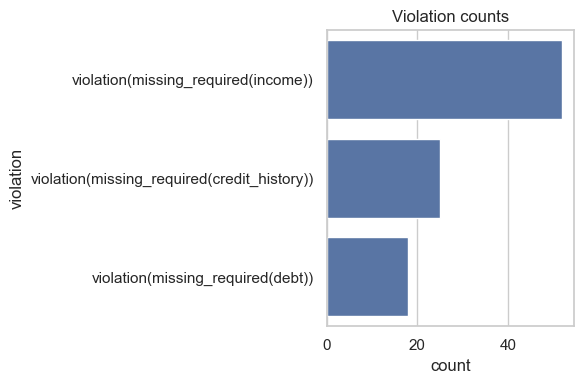

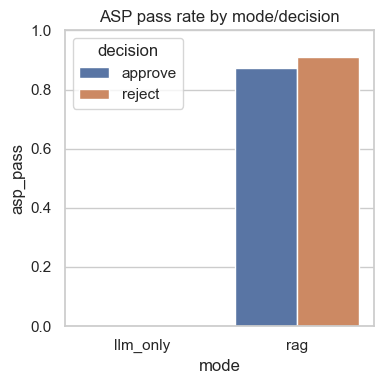

In [56]:
# Load and summarize compliance metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics_path = ROOT / 'notebooks' / 'models' / 'compliance_metrics.csv'
metrics_df = pd.read_csv(metrics_path)
print(metrics_df[['mode','decision','asp_pass','violation_count']].head())

# Pass rate by mode
pass_rate = metrics_df.groupby('mode')['asp_pass'].mean().reset_index()
print(" Pass rate by mode:", pass_rate)

# Pass rate by mode and decision
pass_mode_decision = metrics_df.groupby(['mode','decision'])['asp_pass'].mean().reset_index()
print("Pass rate by mode and decision: ", pass_mode_decision)

# Violation counts by type
viol_expanded = metrics_df.copy()
viol_expanded['violations'] = viol_expanded['violations'].apply(lambda x: eval(x) if isinstance(x, str) else x)
violations_flat = []
for _, row in viol_expanded.iterrows():
    for v in row['violations']:
        violations_flat.append({'mode': row['mode'], 'decision': row['decision'], 'violation': v})
viol_df = pd.DataFrame(violations_flat)
if not viol_df.empty:
    viol_counts = viol_df['violation'].value_counts()
    print(" Top violations:", viol_counts)

    plt.figure(figsize=(6,4))
    sns.countplot(y='violation', data=viol_df, order=viol_df['violation'].value_counts().index)
    plt.title('Violation counts')
    plt.tight_layout()
    plt.show()

# Pass rate bar chart
plt.figure(figsize=(4,4))
sns.barplot(data=pass_mode_decision, x='mode', y='asp_pass', hue='decision')
plt.ylim(0,1)
plt.title('ASP pass rate by mode/decision')
plt.tight_layout()
plt.show()


##### ASP pass/fail by decision and mode
Visualize counts of approvals/rejections that pass or fail ASP for LLM-only vs RAG.


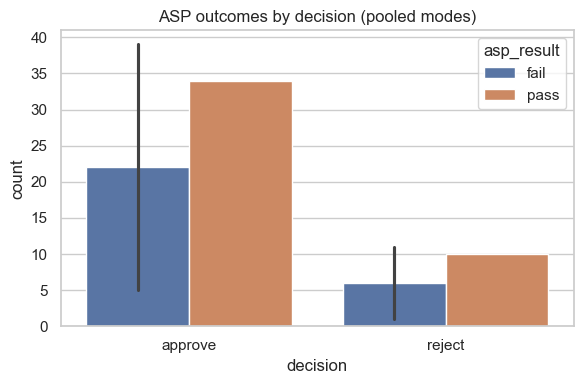

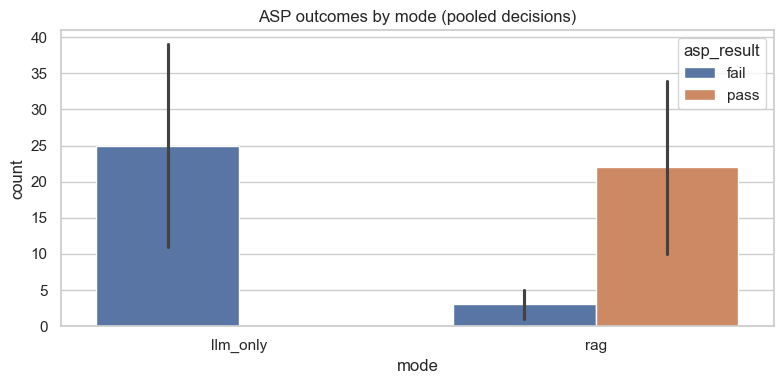

<Figure size 800x500 with 0 Axes>

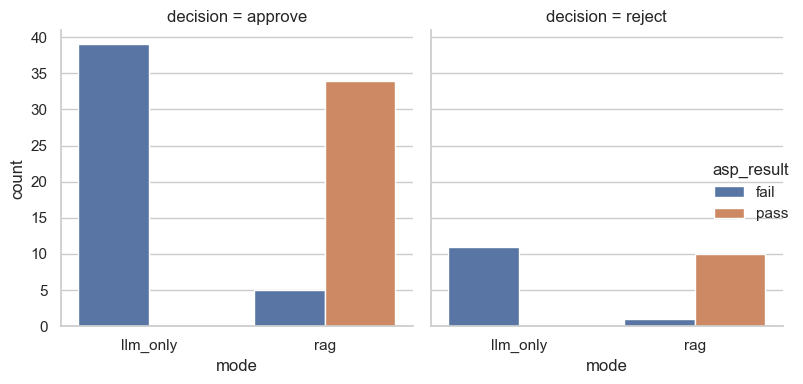

In [57]:
# ASP pass/fail by decision and mode
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics_path = ROOT / 'notebooks' / 'models' / 'compliance_metrics.csv'
metrics_df = pd.read_csv(metrics_path)

metrics_df['asp_result'] = metrics_df['asp_pass'].map({True: 'pass', False: 'fail'})
counts = metrics_df.groupby(['mode','decision','asp_result']).size().reset_index(name='count')

plt.figure(figsize=(6,4))
sns.barplot(data=counts, x='decision', y='count', hue='asp_result')
plt.title('ASP outcomes by decision (pooled modes)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=counts, x='mode', y='count', hue='asp_result')
plt.title('ASP outcomes by mode (pooled decisions)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.catplot(data=counts, x='mode', y='count', hue='asp_result', col='decision', kind='bar', height=4, aspect=0.9)
plt.tight_layout()
plt.show()


##### ASP pass/fail by decision and mode (percentage)
Visualize % of approvals/rejections passing/failing ASP for LLM-only vs RAG.


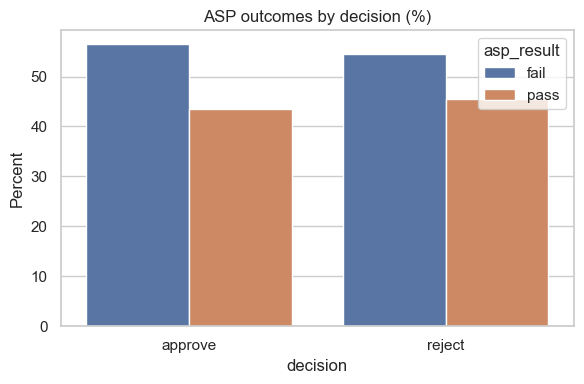

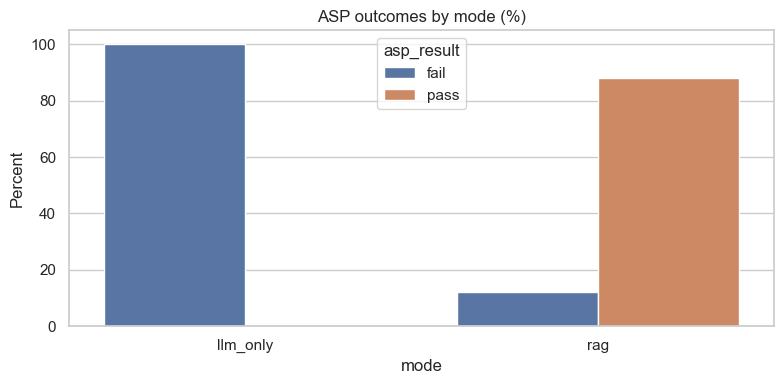

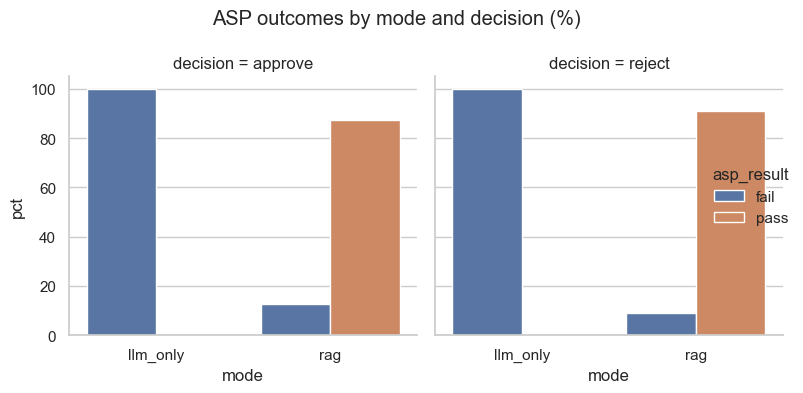

In [58]:
# ASP pass/fail by decision and mode (percentage)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

metrics_path = ROOT / 'notebooks' / 'models' / 'compliance_metrics.csv'
metrics_df = pd.read_csv(metrics_path)
metrics_df['asp_result'] = metrics_df['asp_pass'].map({True: 'pass', False: 'fail'})

# Percentage by decision (pooled modes)
counts_dec = metrics_df.groupby(['decision','asp_result']).size().reset_index(name='count')
counts_dec['pct'] = counts_dec.groupby('decision')['count'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(6,4))
sns.barplot(data=counts_dec, x='decision', y='pct', hue='asp_result')
plt.title('ASP outcomes by decision (%)')
plt.ylabel('Percent')
plt.tight_layout()
plt.show()

# Percentage by mode (pooled decisions)
counts_mode = metrics_df.groupby(['mode','asp_result']).size().reset_index(name='count')
counts_mode['pct'] = counts_mode.groupby('mode')['count'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(8,4))
sns.barplot(data=counts_mode, x='mode', y='pct', hue='asp_result')
plt.title('ASP outcomes by mode (%)')
plt.ylabel('Percent')
plt.tight_layout()
plt.show()

# Percentage by mode and decision
counts_md = metrics_df.groupby(['mode','decision','asp_result']).size().reset_index(name='count')
counts_md['pct'] = counts_md.groupby(['mode','decision'])['count'].transform(lambda x: x / x.sum() * 100)

g = sns.catplot(data=counts_md, x='mode', y='pct', hue='asp_result', col='decision', kind='bar', height=4, aspect=0.9)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('ASP outcomes by mode and decision (%)')
plt.tight_layout()
plt.show()


##### Expanded metrics suite (faithfulness, completeness, ontology, compliance, regulatory adequacy)
Uses existing artifacts (faithfulness CSVs, compliance_metrics.csv, ontology mapping) to summarize per mode.


Aggregated metrics (per mode/decision):
       mode decision  asp_pass  violation_count  completeness  \
0  llm_only  approve  0.000000         1.743590      0.418803   
1  llm_only   reject  0.000000         1.909091      0.363636   
2       rag  approve  0.871795         0.128205      0.957265   
3       rag   reject  0.909091         0.090909      0.969697   

   ontology_alignment  regulatory_hit  
0            0.229853             0.0  
1            0.178355             0.0  
2            0.333588             1.0  
3            0.328102             1.0  
Faithfulness aggregate:
           model  top_k  n_samples  mean_prob_drop  median_prob_drop
0  random_forest      3         50        0.104102          0.130555
Saved expanded metrics to /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/notebooks/models/compliance_metrics_expanded.csv


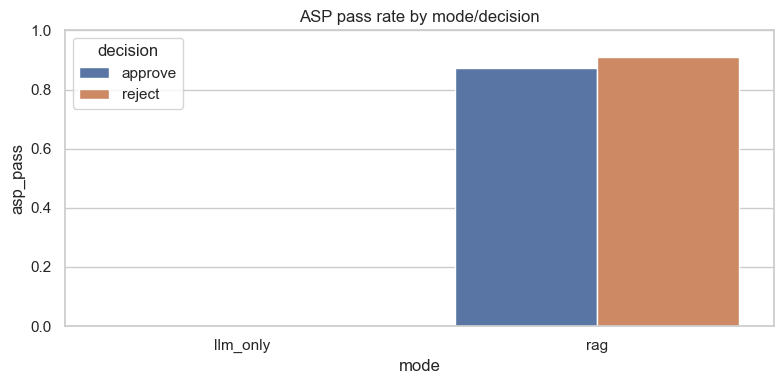

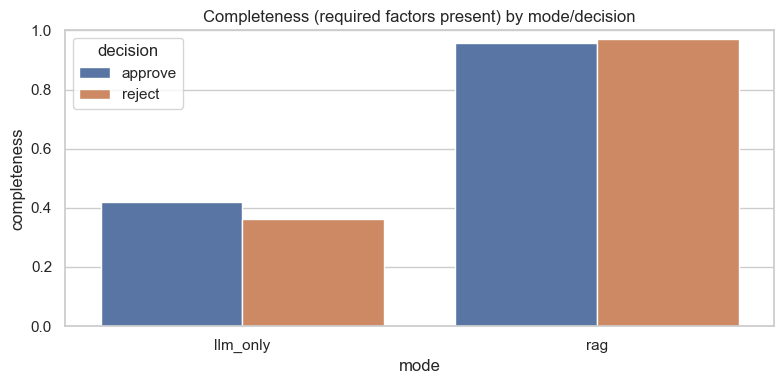

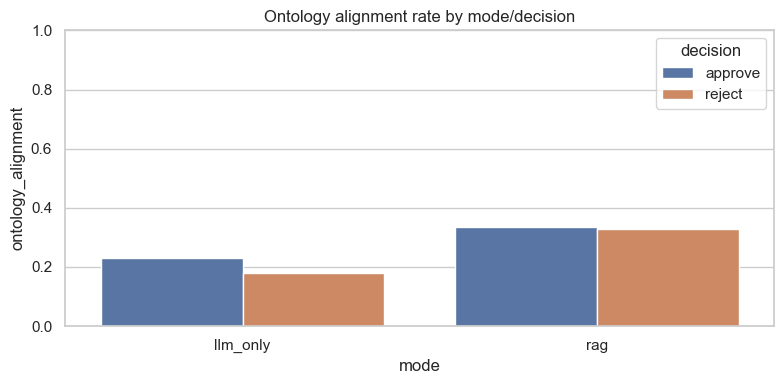

In [59]:
# Expanded metrics suite
import json, re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
faith_summary_path = ROOT / 'notebooks' / 'models' / 'faithfulness_summary.csv'
faith_agg_path = ROOT / 'notebooks' / 'models' / 'faithfulness_agg_summary.csv'
compliance_path = ROOT / 'notebooks' / 'models' / 'compliance_metrics.csv'
ontology_path = ROOT / 'notebooks' / 'ontology' / 'mapping.json'

# Load compliance metrics
comp_df = pd.read_csv(compliance_path)
comp_df['asp_result'] = comp_df['asp_pass'].map({True: 'pass', False: 'fail'})
comp_df['factors'] = comp_df['factors'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
comp_df['top_features'] = comp_df['top_features'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Load faithfulness
faith_df = pd.read_csv(faith_summary_path) if faith_summary_path.exists() else None
faith_agg = pd.read_csv(faith_agg_path) if faith_agg_path.exists() else None

# Load ontology mapping
try:
    ontology_map = json.loads(ontology_path.read_text())
except Exception:
    ontology_map = {}
ontology_terms = set()
for v in ontology_map.values():
    if isinstance(v, dict) and 'ontology_term' in v:
        ontology_terms.add(v['ontology_term'].lower())

# Helpers
required_terms = ['income','debt','credit_history']
reg_keywords = ['gdpr','basel','mifid','regulation','transparency','solvency']

def completeness_rate(factors):
    present = set(factors)
    missing = [t for t in required_terms if t not in present]
    return 1.0 if not missing else 1.0 - len(missing)/len(required_terms)

# Expand metrics per row
rows = []
for _, row in comp_df.iterrows():
    factors = row['factors'] if isinstance(row['factors'], list) else []
    # completeness
    comp_score = completeness_rate(factors)
    # ontology alignment: count factors matching ontology terms (by substring or exact)
    ont_hits = 0
    if ontology_terms:
        for f in factors:
            if any(term in f.lower() or f.lower() in term for term in ontology_terms):
                ont_hits += 1
        ont_rate = ont_hits / max(1, len(factors))
    else:
        ont_rate = np.nan
    # regulatory adequacy: keyword presence in explanation
    text = row.get('explanation','').lower()
    reg_hit = any(k in text for k in reg_keywords)
    rows.append({
        'idx': row.get('idx', None),
        'mode': row['mode'],
        'decision': row['decision'],
        'asp_pass': row['asp_pass'],
        'violation_count': row['violation_count'],
        'completeness': comp_score,
        'ontology_alignment': ont_rate,
        'regulatory_hit': reg_hit,
    })
metrics_expanded = pd.DataFrame(rows)

# Aggregate by mode/decision
agg = metrics_expanded.groupby(['mode','decision']).agg({
    'asp_pass':'mean',
    'violation_count':'mean',
    'completeness':'mean',
    'ontology_alignment':'mean',
    'regulatory_hit':'mean'
}).reset_index()
print("Aggregated metrics (per mode/decision):")
print(agg)

# Faithfulness summary
if faith_agg is not None:
    print("Faithfulness aggregate:")
    print(faith_agg)
elif faith_df is not None:
    print("Faithfulness mean prob drop:", faith_df['prob_drop'].mean())

# Save expanded metrics
metrics_suite_path = ROOT / 'notebooks' / 'models' / 'compliance_metrics_expanded.csv'
metrics_expanded.to_csv(metrics_suite_path, index=False)
print(f"Saved expanded metrics to {metrics_suite_path}")

# Plots: compliance coverage and completeness
plt.figure(figsize=(8,4))
sns.barplot(data=agg, x='mode', y='asp_pass', hue='decision')
plt.title('ASP pass rate by mode/decision')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=agg, x='mode', y='completeness', hue='decision')
plt.title('Completeness (required factors present) by mode/decision')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=agg, x='mode', y='ontology_alignment', hue='decision')
plt.title('Ontology alignment rate by mode/decision')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


### Paired comparison: LLM-only vs RAG
Paired tests on completeness, ontology alignment, ASP pass between modes; reports mean deltas and p-values (t-test, Wilcoxon).


In [60]:
# Paired comparison: llm_only vs rag (uses expanded metrics if available)
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon

expanded_path = ROOT / 'notebooks' / 'models' / 'compliance_metrics_expanded.csv'
base_path = ROOT / 'notebooks' / 'models' / 'compliance_metrics.csv'
if expanded_path.exists():
    m = pd.read_csv(expanded_path)
else:
    m = pd.read_csv(base_path)

# If idx missing, fabricate deterministic pairing index
if 'idx' not in m.columns:
    m['idx'] = range(len(m))

needed = ['mode','decision','idx']
for col in needed:
    if col not in m.columns:
        raise KeyError(f"Missing column {col} in metrics file")

available_metrics = [c for c in ['completeness','ontology_alignment','asp_pass'] if c in m.columns]
if not available_metrics:
    raise KeyError("No completeness/ontology/asp_pass columns found. Run expanded metrics suite first.")

wide = m.pivot_table(index=['idx','decision'], columns='mode', values=available_metrics)
wide.columns = ['_'.join(col).strip() for col in wide.columns.values]
wide = wide.dropna()

results = []
for metric in ['completeness','ontology_alignment','asp_pass']:
    col_rag = f"{metric}_rag"
    col_llm = f"{metric}_llm_only"
    if col_rag not in wide or col_llm not in wide:
        continue
    x = wide[col_llm]
    y = wide[col_rag]
    delta = (y - x).mean()
    t_p = ttest_rel(y, x, nan_policy='omit').pvalue if len(y)==len(x) else float('nan')
    try:
        w_p = wilcoxon(y, x).pvalue
    except ValueError:
        w_p = float('nan')
    results.append({
        'metric': metric,
        'mean_llm_only': x.mean(),
        'mean_rag': y.mean(),
        'mean_delta_rag_minus_llm': delta,
        'p_ttest': t_p,
        'p_wilcoxon': w_p,
    })

res_df = pd.DataFrame(results)
print("Paired comparison (LLM-only vs RAG):")
print(res_df)

out_path = ROOT / 'notebooks' / 'models' / 'compliance_metrics_paired.csv'
res_df.to_csv(out_path, index=False)
print(f"Saved paired comparison to {out_path}")


Paired comparison (LLM-only vs RAG):
               metric  mean_llm_only  mean_rag  mean_delta_rag_minus_llm  \
0        completeness       0.406667  0.960000                  0.553333   
1  ontology_alignment       0.218524  0.332381                  0.113857   
2            asp_pass       0.000000  0.880000                  0.880000   

        p_ttest    p_wilcoxon  
0  4.523368e-23  5.143630e-10  
1  3.113983e-12  9.655808e-09  
2  3.320257e-24  3.283759e-11  
Saved paired comparison to /Users/rathnagirinagarajan/ResearchCoding/masters-thesis-xai-credit-research/notebooks/models/compliance_metrics_paired.csv


# Lightweight Counterfactual Module

#### Counterfactual demo (simple JSON prompt + fidelity check)
Generates a minimal counterfactual via LLM, applies changes, checks if prediction flips, and reports fidelity.


##### Initial prototype

In [61]:
# Very minimal changes by asking llm to propose minimal changes and test fidelity
import json
import pandas as pd
import joblib
from src.rag import LLMClient

pipe = joblib.load('models/random_forest_pipeline.joblib')
X_test = pd.read_csv('models/X_test_raw.csv')
preds = pipe.predict(X_test)
probas = pipe.predict_proba(X_test)[:, 1]

reject_idx = next((i for i, p in enumerate(preds) if p == 0), None)
if reject_idx is None:
    raise RuntimeError('No reject cases found to generate counterfactuals.')

raw_row = X_test.iloc[[reject_idx]].copy()
orig_prob = probas[reject_idx]
orig_pred = preds[reject_idx]

prompt = (
    "You generate minimal, realistic counterfactual edits to flip a credit decision from reject to approve.\n"
    "Return JSON with a list of changes, each having feature and new_value. Keep edits realistic (no ignoring history).\n"
    f"Original features (dict): {raw_row.iloc[0].to_dict()}\n"
    "Target decision: approve.\n"
    'Output format: {"changes": [{"feature": "feature_name", "new_value": value}]}'
)

client = LLMClient(provider='openai', openai_model='gpt-4o-mini', local_model='sshleifer/tiny-gpt2')
response = client.generate(prompt, temperature=0.2)
print('LLM response:', response)

# Parse potential fenced JSON
changes = []

def _strip_code_fence(text):
    if text is None:
        return ''
    t = str(text).strip()
    if t.startswith('```'):
        t = t.strip('`')
        if t.lower().startswith('json'):
            t = t[len('json'):].lstrip()
    return t

try:
    cleaned = _strip_code_fence(response)
    parsed = json.loads(cleaned)
    changes = parsed.get('changes', []) if isinstance(parsed, dict) else []
except Exception as e:
    print('Failed to parse JSON, skipping changes:', e)

# Helper to apply changes with basic type coercion
numeric_cols_local = numeric_cols if 'numeric_cols' in globals() else []

def apply_changes(base_df, changes):
    df = base_df.copy()
    applied = []
    for ch in changes:
        if not isinstance(ch, dict):
            continue
        feat = ch.get('feature')
        new_val = ch.get('new_value')
        if feat and feat in df.columns:
            if feat in numeric_cols_local:
                try:
                    new_val = float(new_val)
                except Exception:
                    pass
            df.at[df.index[0], feat] = new_val
            applied.append((feat, new_val))
    return df, applied

cf_row, applied = apply_changes(raw_row, changes)
cf_pred = pipe.predict(cf_row)[0]
cf_prob = pipe.predict_proba(cf_row)[0, 1]
fidelity = (orig_pred != cf_pred)

# If not flipped, try a simple deterministic nudge on key debt-related features
if not fidelity:
    nudges = []
    if 'credit_amount' in cf_row.columns:
        nudges.append({'feature': 'credit_amount', 'new_value': float(cf_row.iloc[0]['credit_amount']) * 0.8})
    if 'installment_rate' in cf_row.columns:
        nudges.append({'feature': 'installment_rate', 'new_value': 1})
    cf_row2, applied2 = apply_changes(cf_row, nudges)
    cf_pred2 = pipe.predict(cf_row2)[0]
    cf_prob2 = pipe.predict_proba(cf_row2)[0, 1]
    if cf_pred2 != orig_pred:
        cf_row, applied = cf_row2, applied + applied2
        cf_pred, cf_prob, fidelity = cf_pred2, cf_prob2, True
    else:
        print('Fallback nudges did not flip the decision.')

print(f"Original pred={orig_pred} prob={orig_prob:.3f}; CF pred={cf_pred} prob={cf_prob:.3f}")
print('Applied changes:', applied)
print('Fidelity (flipped decision):', fidelity)

cf_result = pd.DataFrame([{
    'idx': reject_idx,
    'orig_pred': int(orig_pred),
    'orig_prob': float(orig_prob),
    'cf_pred': int(cf_pred),
    'cf_prob': float(cf_prob),
    'fidelity_flip': bool(fidelity),
    'applied_changes': applied,
}])
cf_result.to_csv('models/counterfactual_result.csv', index=False)
print('Saved counterfactual_result.csv')


LLM response: ```json
{
  "changes": [
    {"feature": "credit_history", "new_value": "A32"},
    {"feature": "employment", "new_value": "A73"},
    {"feature": "installment_rate", "new_value": 2},
    {"feature": "existing_credits", "new_value": 0}
  ]
}
```
Original pred=0 prob=0.470; CF pred=1 prob=0.506
Applied changes: [('credit_history', 'A32'), ('employment', 'A73'), ('installment_rate', 2.0), ('existing_credits', 0.0), ('credit_amount', 3192.0), ('installment_rate', 1.0)]
Fidelity (flipped decision): True
Saved counterfactual_result.csv


#### Counterfactual fidelity metrics (heuristic batch)
Applies a simple heuristic counterfactual (reduce credit_amount, set installment_rate=1) on a batch of rejects and reports flip rate.


##### Optimize using deterministic heuristic


Algorithm: Deterministic heuristic
- Applies fixed edits to reject cases: reduce **credit_amount** by 20%, set **installment_rate** to 1.
- Scores with tuned RF; computes flip rate and probability deltas.
- Outputs: counterfactual_fidelity.csv and bar plot of flips vs no-flips.


   idx  orig_pred  orig_prob  cf_pred   cf_prob  fidelity_flip  \
0    1          0   0.469674        1  0.524883           True   
1    8          0   0.457698        0  0.432540          False   
2   13          0   0.360982        0  0.430204          False   
3   25          0   0.392517        0  0.402517          False   
4   27          0   0.439380        1  0.556284           True   

                                     applied_changes  
0   [(credit_amount, 3192.0), (installment_rate, 1)]  
1  [(credit_amount, 2491.2000000000003), (install...  
2   [(credit_amount, 1476.0), (installment_rate, 1)]  
3   [(credit_amount, 4888.0), (installment_rate, 1)]  
4  [(credit_amount, 10380.800000000001), (install...  
Flip rate: 30.00% over 20 reject cases
Saved counterfactual_fidelity.csv


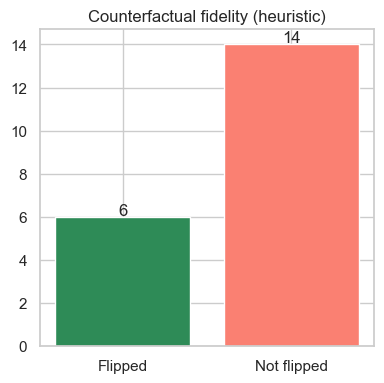

In [62]:
# Counterfactual fidelity metrics over a batch of rejects (deterministic heuristic, no extra LLM calls)
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

pipe = joblib.load('models/random_forest_pipeline.joblib')
X_test = pd.read_csv('models/X_test_raw.csv')
preds = pipe.predict(X_test)
probas = pipe.predict_proba(X_test)[:,1]

reject_indices = [i for i,p in enumerate(preds) if p==0]
sample_n = min(20, len(reject_indices))
reject_indices = reject_indices[:sample_n]

def apply_heuristic_cf(row):
    cf = row.copy()
    changes = []
    if 'credit_amount' in cf:
        cf['credit_amount'] = float(cf['credit_amount']) * 0.8
        changes.append(('credit_amount', cf['credit_amount']))
    if 'installment_rate' in cf:
        cf['installment_rate'] = 1
        changes.append(('installment_rate', cf['installment_rate']))
    return cf, changes

records = []
for idx in reject_indices:
    base_row = X_test.iloc[[idx]].copy()
    base_pred = preds[idx]
    base_prob = probas[idx]
    cf_row_dict, changes = apply_heuristic_cf(base_row.iloc[0].to_dict())
    cf_row = pd.DataFrame([cf_row_dict])
    cf_pred = pipe.predict(cf_row)[0]
    cf_prob = pipe.predict_proba(cf_row)[0,1]
    fidelity = (cf_pred != base_pred)
    records.append({
        'idx': idx,
        'orig_pred': int(base_pred),
        'orig_prob': float(base_prob),
        'cf_pred': int(cf_pred),
        'cf_prob': float(cf_prob),
        'fidelity_flip': bool(fidelity),
        'applied_changes': changes,
    })

cf_df = pd.DataFrame(records)
flip_rate = cf_df['fidelity_flip'].mean() if not cf_df.empty else 0.0
print(cf_df.head())
print(f"Flip rate: {flip_rate:.2%} over {len(cf_df)} reject cases")

Path('models').mkdir(exist_ok=True)
cf_df.to_csv('models/counterfactual_fidelity.csv', index=False)
print('Saved counterfactual_fidelity.csv')

# Plot flips vs no flips
plt.figure(figsize=(4,4))
counts = cf_df['fidelity_flip'].value_counts()
labels = ['Flipped','Not flipped']
values = [counts.get(True,0), counts.get(False,0)]
plt.bar(labels, values, color=['seagreen','salmon'])
plt.title('Counterfactual fidelity (heuristic)')
for i,v in enumerate(values):
    plt.text(i, v+0.1, str(v), ha='center')
plt.tight_layout()
plt.savefig('models/counterfactual_fidelity_bar.png', dpi=200)
plt.show()


#### Final Improved method for Counterfactuals

Algorithm: LLM + heuristics
- For each reject: LLM suggests JSON changes; pipeline handles encoding.
- Applies changes with type coercion; if no flip, applies stronger nudges (credit_amount x0.7, installment_rate=1, duration x0.8, savings_status->A64).
- Records flip rate, delta_prob, n_changes; saves detailed results/metrics.

In [63]:
import numpy as np
import json
from src.rag import LLMClient

# Derive numeric columns from X_test (used for basic type coercion)
numeric_cols_local = X_test.select_dtypes(include=["int64", "float64"]).columns.tolist()

def _strip_code_fence_local(text):
    if text is None:
        return ''
    t = str(text).strip()
    if t.startswith('```'):
        t = t.strip('`')
        if t.lower().startswith('json'):
            t = t[len('json'):].lstrip()
    return t

def apply_changes_dict(row_dict, changes):
    df = row_dict.copy()
    applied = []
    for ch in changes:
        if not isinstance(ch, dict):
            continue
        feat = ch.get('feature')
        new_val = ch.get('new_value')
        if feat in df:
            if feat in numeric_cols_local:
                try:
                    new_val = float(new_val)
                except Exception:
                    pass
            df[feat] = new_val
            applied.append((feat, new_val))
    return df, applied


def run_counterfactual_for_idx(idx):
    """
    LLM-based counterfactual with fallback nudges for a single reject case.
    Returns dict with original/CF preds/probs, delta, flip flag, and applied changes.
    """
    if preds[idx] != 0:
        return None

    raw_row = X_test.iloc[[idx]].copy()
    orig_prob = float(probas[idx])
    orig_pred = int(preds[idx])

    prompt = (
        "You generate minimal, realistic counterfactual edits to flip a credit decision from reject to approve."
        "Return JSON with a list of changes, each having feature and new_value. Keep edits realistic (no ignoring history)."
        f"Original features (dict): {raw_row.iloc[0].to_dict()}"
        "Target decision: approve."
        "Output format: {\"changes\": [{\"feature\": \"feature_name\", \"new_value\": value}]}"
    )

    client = LLMClient(provider='openai', openai_model='gpt-4o-mini', local_model='sshleifer/tiny-gpt2')
    response = client.generate(prompt, temperature=0.2)

    changes = []
    try:
        cleaned = _strip_code_fence_local(response)
        parsed = json.loads(cleaned)
        changes = parsed.get('changes', []) if isinstance(parsed, dict) else []
    except Exception as e:
        print('Failed to parse JSON for idx', idx, e)

    cf_dict, applied = apply_changes_dict(raw_row.iloc[0].to_dict(), changes)
    cf_row = pd.DataFrame([cf_dict])
    cf_pred = int(pipe.predict(cf_row)[0])
    cf_prob = float(pipe.predict_proba(cf_row)[0, 1])
    fidelity = (cf_pred != orig_pred)

    # Fallback nudges if no flip
    if not fidelity:
        # stronger fallback nudges: reduce debt burden, shorten term, boost savings
        nudges = []
        if 'credit_amount' in cf_dict:
            nudges.append({'feature': 'credit_amount', 'new_value': float(cf_dict['credit_amount']) * 0.7})
        if 'installment_rate' in cf_dict:
            nudges.append({'feature': 'installment_rate', 'new_value': 1})
        if 'duration' in cf_dict:
            nudges.append({'feature': 'duration', 'new_value': float(cf_dict['duration']) * 0.8})
        if 'savings_status' in cf_dict:
            nudges.append({'feature': 'savings_status', 'new_value': 'A64'})  # higher savings
        cf_dict2, applied2 = apply_changes_dict(cf_dict, nudges)
        cf_row2 = pd.DataFrame([cf_dict2])
        cf_pred2 = int(pipe.predict(cf_row2)[0])
        cf_prob2 = float(pipe.predict_proba(cf_row2)[0, 1])
        if cf_pred2 != orig_pred:
            cf_dict, cf_row, applied = cf_dict2, cf_row2, applied + applied2
            cf_pred, cf_prob, fidelity = cf_pred2, cf_prob2, True

    delta_prob = cf_prob - orig_prob
    return {
        'idx': idx,
        'orig_pred': orig_pred,
        'orig_prob': orig_prob,
        'cf_pred': cf_pred,
        'cf_prob': cf_prob,
        'delta_prob': delta_prob,
        'fidelity_flip': fidelity,
        'n_changes': len(applied),
        'applied_changes': applied,
    }


In [64]:
# Collect a subset of reject indices
reject_indices = [i for i, p in enumerate(preds) if p == 0]
print("Total reject cases in test set:", len(reject_indices))

results = []
max_cases = 20  # or any number you like
for idx in reject_indices[:max_cases]:
    res = run_counterfactual_for_idx(idx)
    if res is not None:
        results.append(res)

cf_results_all = pd.DataFrame(results)
cf_results_all.to_csv('models/counterfactual_results_all.csv', index=False)

print("Head of counterfactual_results_all:")
print(cf_results_all.head())
print("\nSaved counterfactual_results_all.csv with", len(cf_results_all), "rows.")


Total reject cases in test set: 38
Head of counterfactual_results_all:
   idx  orig_pred  orig_prob  cf_pred   cf_prob  delta_prob  fidelity_flip  \
0    1          0   0.469674        1  0.560851    0.091177           True   
1    8          0   0.457698        1  0.518278    0.060580           True   
2   13          0   0.360982        0  0.356585   -0.004396          False   
3   25          0   0.392517        1  0.604656    0.212139           True   
4   27          0   0.439380        1  0.553403    0.114023           True   

   n_changes                                    applied_changes  
0          8  [(credit_history, A32), (employment, A73), (in...  
1          8  [(credit_history, A31), (employment, A71), (in...  
2          4  [(credit_history, A31), (credit_amount, 1500.0...  
3          8  [(credit_history, A32), (employment, A72), (in...  
4          4  [(credit_history, A31), (credit_amount, 10000....  

Saved counterfactual_results_all.csv with 20 rows.


In [65]:
# Basic flip-rate and probability-change metrics + save table
if not cf_results_all.empty:
    flip_rate = cf_results_all['fidelity_flip'].mean()
    avg_delta = cf_results_all['delta_prob'].mean()
    avg_delta_flip = cf_results_all.loc[cf_results_all['fidelity_flip'], 'delta_prob'].mean()
    avg_delta_no_flip = cf_results_all.loc[~cf_results_all['fidelity_flip'], 'delta_prob'].mean()
    avg_changes_flip = cf_results_all.loc[cf_results_all['fidelity_flip'], 'n_changes'].mean()
    avg_changes_no_flip = cf_results_all.loc[~cf_results_all['fidelity_flip'], 'n_changes'].mean()
    summary = pd.DataFrame([
        {'metric':'flip_rate','value': flip_rate},
        {'metric':'avg_delta_prob_all','value': avg_delta},
        {'metric':'avg_delta_prob_flipped','value': avg_delta_flip},
        {'metric':'avg_delta_prob_not_flipped','value': avg_delta_no_flip},
        {'metric':'avg_n_changes_flipped','value': avg_changes_flip},
        {'metric':'avg_n_changes_not_flipped','value': avg_changes_no_flip},
    ])
    print("Fidelity summary metrics:")
    print(summary)
    cf_results_all.to_csv('models/counterfactual_method2_results.csv', index=False)
    summary.to_csv('models/counterfactual_method2_metrics.csv', index=False)
else:
    print("No counterfactual results available.")


Fidelity summary metrics:
                       metric     value
0                   flip_rate  0.850000
1          avg_delta_prob_all  0.140878
2      avg_delta_prob_flipped  0.164777
3  avg_delta_prob_not_flipped  0.005451
4       avg_n_changes_flipped  6.823529
5   avg_n_changes_not_flipped  4.000000


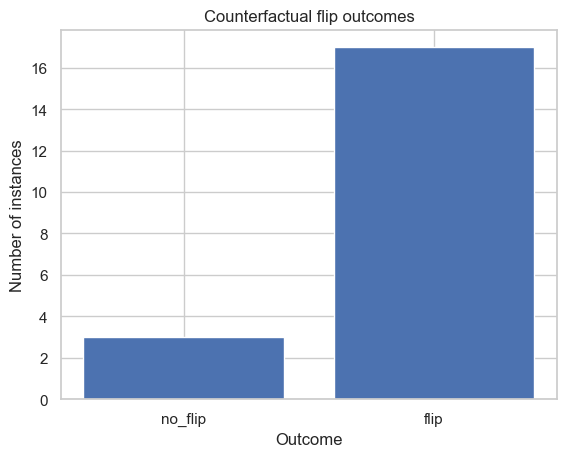

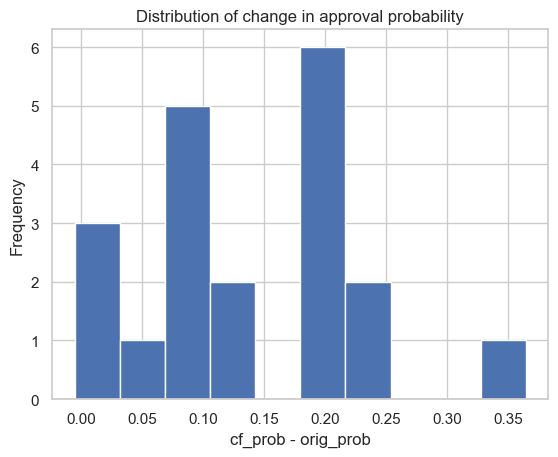

In [66]:
import matplotlib.pyplot as plt

if not cf_results_all.empty:
    # 1) Bar chart: flips vs no flips
    flip_counts = cf_results_all['fidelity_flip'].value_counts().sort_index()
    labels = ['no_flip', 'flip']
    values = [
        flip_counts.get(False, 0),
        flip_counts.get(True, 0)
    ]

    plt.figure()
    plt.bar(labels, values)
    plt.title("Counterfactual flip outcomes")
    plt.xlabel("Outcome")
    plt.ylabel("Number of instances")
    plt.show()

    # 2) Histogram: change in approval probability (cf_prob - orig_prob)
    plt.figure()
    cf_results_all['delta_prob'].hist(bins=10)
    plt.title("Distribution of change in approval probability")
    plt.xlabel("cf_prob - orig_prob")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No counterfactual results available for plotting.")
